# How do I pre-process text data from Yelp reviews so I can analyze it?

## Introduction

**Business Context.** You are a business consultant for small and medium-sized businesses with a large number of customers. Examples of such businesses might include a quick-dining restaurant, clothing store, or online distributor of hobby equipment. You would like to help your small businesses understand what factors are driving positive and negative customer experiences. Customers are often unwilling to give direct feedback, but do leave large numbers of online reviews on websites such as Yelp, Amazon, and so on. You would like to develop a service that would allow businesses to quickly obtain useful summaries of their reviews across such websites. Such a service would allow your clients to answer questions like: "What are the most important factors driving negative reviews?" or "Did a recent policy change improve our reviews?"

**Business Problem.** Your main task is to **wrangle a dataset of text reviews and engineer relevant features in order to facilitate subsequent analysis and model building**.

**Analytical Context.** Text data is highly unstructured, and often requires pre-processing before we can gather any business insights from it. We will be leveraging tools from **natural language processing (NLP)** in order to help us process this data and generate new features that can be used for analytics or model building.

The case will proceed as follows: we will (1) introduce basic steps of pre-processing like word tokenization and text visualization; (2) introduce key tools in feature extraction such as n-grams, count representations, stop words, and TF-IDF; (3) leverage these tools to perform exploratory data analysis; and finally (4) look at pure text wrangling tools like regular expressions.

## Context about NLP

Some of the most famous success stories involving NLP come from Google, where it is used to give very good responses to vague or misspelled internet searches, as well as fairly comprehensible automatic translations of plain text.

There is often quite a bit of misconception surrounding NLP and its place within machine learning as a whole. Many of the uninitiated think that NLP is just machine learning applied to words. However, this is far from true. NLP has two characteristics which make it intractable for naive applications of machine learning:

### Challenge 1: Extraordinarily high dimensionality

Consider the book *War and Peace*. It has 3 million characters. Can we view this as a long vector of strings taking values in a 3-million-dimensional space, and then apply machine learning methods here? This is a bad idea for two reasons:

1. Basic approaches have terrible performance in such high-dimensional spaces
2. These approaches "miss out" on some important rules about language that we all know; e.g. that "don't" and "do not" mean the same thing

As a result, a huge amount of NLP involves finding ways to summarize incredibly long vectors in concise ways, so that we can tractably explore, analyze, and model build with them later.

### Challenge 2: Text is context specific

For example, the word *queen* has many uses in English that are both *very different* and *common*:

1. The ruler of a country
2. A size of mattress
3. The most powerful piece in chess
4. The mother insect in certain types of insect colonies

General purpose libraries will need to deal with all of these, but reviews for mattresses will almost always be about the second. This type of mismatch can result in misleading results that can easily be fixed by a team that is familiar with the underlying NLP computations.

## Pre-processing and standardization

Standardizing text involves many steps. Some of these include:

1. Simple error correction (e.g. removing ASCII coding errors)
2, Feature creation (e.g. labeling nouns and verbs)
3. Replacing words and sentences altogether (e.g. standardizing spelling by changing "yuuuuuuck!" to "yuck", or more extreme steps such as replacing words with near synonyms)

In a broad sense, standardization is similar to data wrangling with more conventional data; we are fixing errors, removing outliers, and transforming features. However, the details in NLP tend to be more complicated. We will be using Python's Natural Languages Toolkit (`nltk`) library. This library has functions that do most of the basics in NLP.

**NOTE:** *Many text wrangling pipelines start a little before we do, with initial "cleaning" steps that involve things like: converting all characters to lower case, expanding contractions, etc. Our main reason for skipping this initial step is that you must make some important and very context-sensitive choices in these steps. For example, auto-correcting the spelling of a document can be very helpful in reducing noise (e.g. if there are important and hard-to-spell words in the document, like "Poughkeepsie") but can also destroy the most important part of the signal (e.g. auto-correcting brand names of companies like "Rappi" to "rapping"). Similarly, the steps we outline here may need to be adapted appropriately for other contexts, such as other languages, computer programs, legal documents, etc.* 

In [1]:
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy  as np
import string
import plotly
from nltk.stem import PorterStemmer 

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [2]:
# LOADING THE DATASET AND SEEING THE DETAILS
data = pd.read_csv('sdata.csv')
data.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [3]:
AllReviews = data['text']
AllReviews.head()

0    Super simple place but amazing nonetheless. It...
1    Small unassuming place that changes their menu...
2    Lester's is located in a beautiful neighborhoo...
3    Love coming here. Yes the place always needs t...
4    Had their chocolate almond croissant and it wa...
Name: text, dtype: object

### Tokenizing sentences

Just like CSV data is composed of features, text data is composed of sentences. Thus, a natural first step is what is known as **sentence tokenization**: splitting a long document into its component sentences. At first this might seem trivial: just split whenever you see a period. Unfortunately, the same symbol is used in other ways in English (e.g. to mark an abbreviation, as part of ellipses, etc.), and so slightly more care is required. Fortunately, there are packages that will do this for us. Within `nltk`, we can use the `nltk.sent_tokenize()` function.

### Exercise 1:

Give an example of a question we might be able to answer with this sort of data, and another question that we'd need additional data to answer. Assume for now that all of the reviews are coming from one business.

**Sample Answer.** A human reading this might be able to figure out the most appreciated features of a business by:

1. Looking for features that are consistently praised (e.g. "great customer service")
2. Looking for features that appear most often in positive reviews

On the other hand, it would be very difficult to make any conclusions about how the business is faring with respect to locals vs. tourists based on this dataset.

Here, each "document" is just a single review. Let's take a look at the first "document" review in our dataset, and tokenize it:

In [4]:
# Print text of first Yelp review
AllReviews[0]

"Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly."

In [5]:
# sentence tokenization
sentences = nltk.sent_tokenize(AllReviews[0])
for sentence in sentences:
    print(sentence)
    print()

Super simple place but amazing nonetheless.

It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard.

Staff was very helpful and friendly.



### Tokenizing words

Having split documents into sentences, we now split sentences into individual words. As with sentence tokenization, there is (i) a pretty good heuristic (split on spaces), (ii) a number of weird exceptions (e.g. compound words), and (iii) an existing package that does the job fairly well.

We use the `nltk.word_tokenize()` function from `nltk`:

In [6]:
sentences = nltk.sent_tokenize(data['text'][1])
for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    print(sentence)
    print(words)
    print()

Small unassuming place that changes their menu every so often.
['Small', 'unassuming', 'place', 'that', 'changes', 'their', 'menu', 'every', 'so', 'often', '.']

Cool decor and vibe inside their 30 seat restaurant.
['Cool', 'decor', 'and', 'vibe', 'inside', 'their', '30', 'seat', 'restaurant', '.']

Call for a reservation.
['Call', 'for', 'a', 'reservation', '.']

We had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains.
['We', 'had', 'their', 'beef', 'tartar', 'and', 'pork', 'belly', 'to', 'start', 'and', 'a', 'salmon', 'dish', 'and', 'lamb', 'meal', 'for', 'mains', '.']

Everything was incredible!
['Everything', 'was', 'incredible', '!']

I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go.
['I', 'could', 'go', 'on', 'at', 'length', 'about', 'how', 'all', 'the', 'listed', 'ingredients', 'really', 'make', 'their', 'dishes', 'amazing', 'but', 'honestly', 'you', 'just', 'need', '

### Exercise 2:

Conduct an exploratory analysis of the sizes of reviews: find the shortest and longest reviews, then plot a histogram showing the distribution of review lengths.

**Answer.** One possible solution is shown below:

In [7]:
review_words_lengths = AllReviews.apply(lambda x: len(nltk.word_tokenize(x)))

In [8]:
min(review_words_lengths)

2

In [9]:
## This review has been written in a different language 
AllReviews[review_words_lengths[review_words_lengths == 2].index]

6687    在拉斯维加斯买了新房子，本来想安装布艺窗帘， 但是经过小刘的介绍，知道拉斯维加斯特别热，布艺...
Name: text, dtype: object

In [10]:
max(review_words_lengths)

1148

In [11]:
AllReviews[review_words_lengths[review_words_lengths == max(review_words_lengths)].index]
print(AllReviews[9349])

Alright...this is a bit of a mixed bag review-wise...not because there is some good and bad, but because...well...read the review.

It was my birthday...or a few days later.  A friend and I were celebrating.  Smallman Galley was on my "list" to try.  I didn't know what to expect.  But I think I had in my mind a vision of what this "chef incubator" was going to be.  

Things I didn't expect:  picnic table seating, 4 "store fronts", people lined up ordering from the counter.  So...go into it with that expectation.  I kind of love the idea of the place, but if you were thinking to woo your lady love (or man love, whatevs) with a candle-lit dinner in a cozy restaurant with amazing service...well, you'd  miss the mark.

I had to wait.  My friend was late.  I was sitting at the bar, so I didn't really care.  I perused the menu.  First drink that popped out at me was a Primus song.  "Jerry Was a Race Car Driver" reportedly had:  Amara Sfumato Rabarbaro, Aperol, Genepy des Alpes, pluot syrup, 

In [12]:
## Setting the resolution for better clarity 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
review_words_lengths.hist(bins = 25)

## Text visualization with word clouds

Just like visualization is crucial for standard CSV data, it is also important for text data. But text doesn't lend itself to histograms or scatterplots the way that numerical or even categorical data do. In such cases, **word clouds** are a common and useful tool:

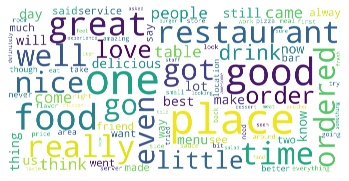

In [13]:
# Importing the required parameter for plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud_text = ''.join(data.text)
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(word_cloud_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Exercise 3:

Write a function `word_cloud_rating(data, star_value)` that constructs a word cloud from the subset of `data` that exhibit a certain `star_value`. Visualize the results of this function for 1-star reviews.

**Answer.** One possible solution is given below:

In [14]:
## Setting the resolution for better clarity 
from pylab import rcParams
rcParams['figure.figsize'] = 30, 60

def word_cloud_rating(data,star_value):
    
    data_filtered = data[data.stars == star_value] #filtering according to the star value
    Reviews = data_filtered.text

    Reviews_text = ' '.join(Reviews.values) #joining all the words together

    # Creating a word cloud object
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(Reviews_text)


    # Plotting the generated word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

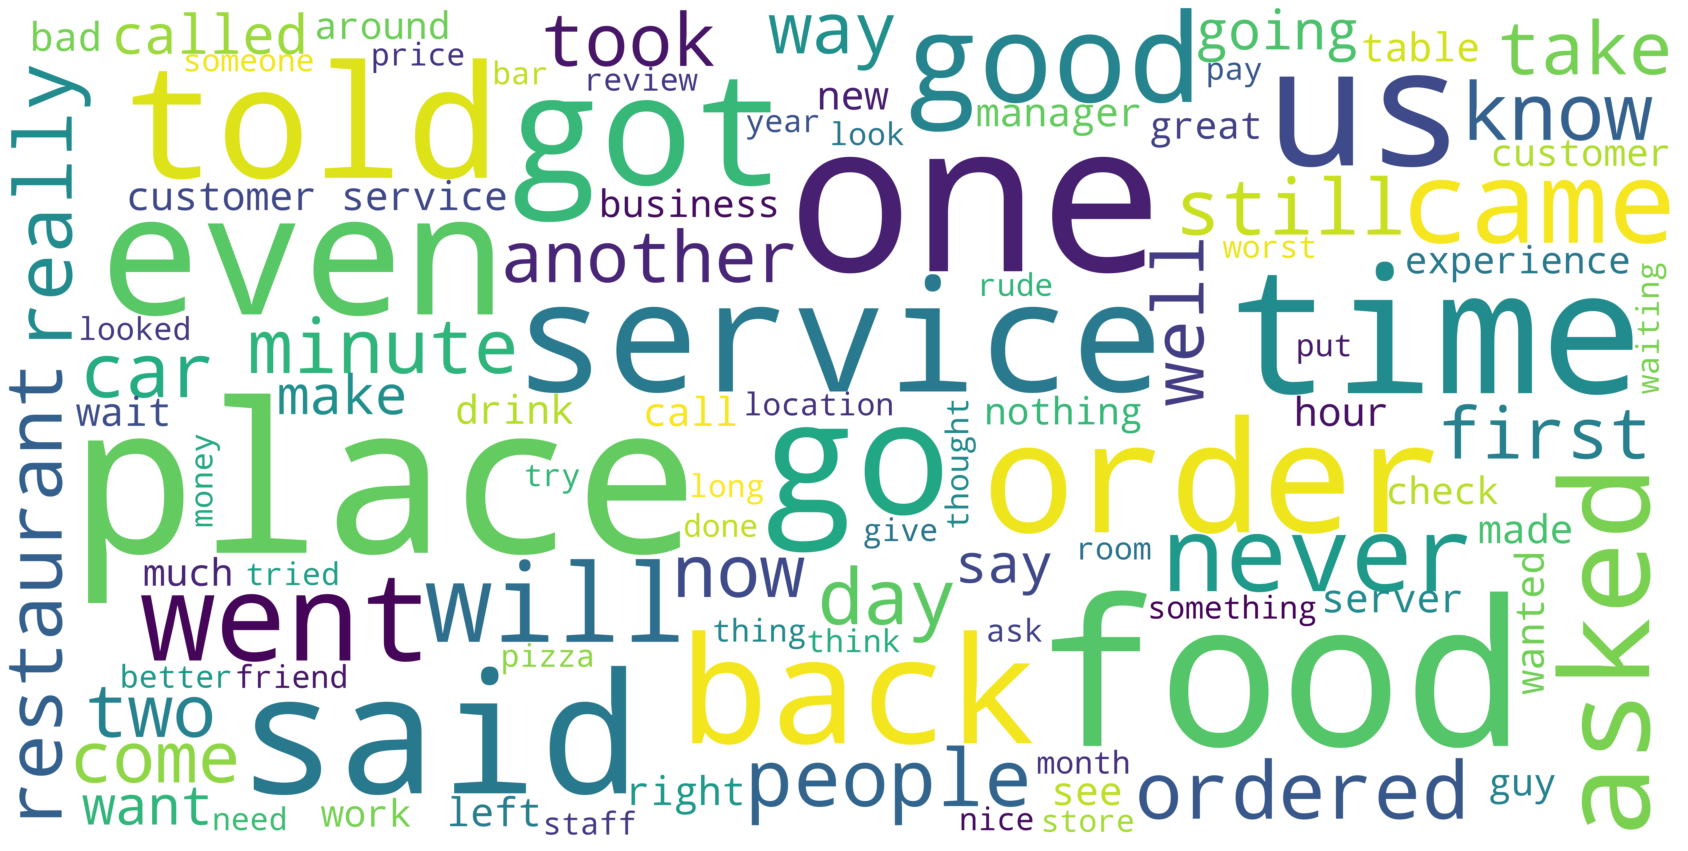

In [15]:
word_cloud_rating(data, 1)

### Exercise 4:

The word "good" seems to appear quite frequently in the negative reviews. Investigate why that is and come up with a reasonable explanation.

 **Answer.** Let's look at the first 5 reviews or so with 1-star ratings to see if there are any discernible patterns:

In [16]:
[each for each in data[data.stars == 1].text if 'good' in each][:5]

['after reading the reviews on yelp, my boyfriend and i decided to give this place a try, especially since we are on a mission to try ramen in every city we visit.\n\nwe were really excited, as when we were in NYC, we had really good ramen. \n\nlistening to the reviews we started off with the gyoza appetizer - which was not as good as everyone says it is. It was pan fried with the thin layer of skin, but there was an aftertaste of soap water. Which I should have known, since the glass of water they served us was disgusting!\n\nWe had ordered the jumbo sumo ramen - beware, it is a very big bowl of noodles, which we did not expect.\n\nThe sumo ramen came with a half boil egg, seaweed, pork belly, and other veggies. The noodles and pork belly was good. Soup was tasteless.\n\nDefinitely would not go back again.',
 "Came here for a friend's birthday. She had looked it up and thought it sound good. First of all, when we made reservations, they only had a 7pm time slot for us (we were looking

Reading each of the reviews, it is clear that good is mentioned in context like "not as good" or "sound good". This indicates that in the world of text we cannot go by single words (also called **1-grams**) alone. The context of the sentence or the surrounding words at least are very much necessary to understand the sentiment of a sentence.

# n-grams

Since 1-grams are insufficient to understand the significance of certain words in our text, it is natural to consider blocks of words, or **n-grams**.

The simplest version of the n-gram model, for $n > 1$, is the **bigram** model, which looks at pairs of consecutive words. For example, the sentence "The quick brown fox jumps over the lazy dog" would have tokens "the quick", "quick brown",..., "lazy dog". The following image (courtesy: google) explains this concept:

![](ngrams.png)

This has obvious advantages and disadvantages over looking at words individually:

1. This retains the structure of the overall document, and
2. It paves the way for analyzing words in contex; however,
3. The dimension is vastly larger

In practice, this last challenge can be truly daunting. As an example, *War and Peace* has 3 million characters, which translates to several hundred thousand 1-grams (words). If you consider that the set of all possible bigrams can be as large as the square of the number of 1-grams, this gets us to a hundred billion possible bigrams! If classical ML techniques are not suitable for training on 3 million characters, how can they possibly deal with a hundred billion dimensions?

For this reason, it is often prudent to start by extracting as much value out of 1-grams as possible, before working our way up to more complex structures.

In this section we also start to look again at our main application: calculating some "interesting" features of our corpus of reviews.

When thinking about word analysis, the main topic of interest is finding an *efficient* and *low-dimensional* representation in order to facilitate document visualization and larger-scale analyses. We discuss two broad categories of word representations:

1. `Count-based representations`: word-word and word-document matrices.
2. `Word embeddings`: spectral embedding, UMAP, word2vec, GloVe, and many many more.

These are often used to assist with downstream tasks such as clustering, ranking and labeling, which will be briefly discussed in a different class.

### Count-based representations

n-grams fall under a broader category of techniques otherwise known as **count-based representations**. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Let's start with 1-grams (words). The simplest type of information would be whether a particular word occurs in particular documents. This leads to **word-document co-occurrence matrices**, where the $(W, X)$ entry of the word-document matrix is set to 1 if word $W$ occurs in document $X$, and 0 otherwise.

There are many variants of this. In lieu of the fact that we are looking for count-based representations of our documents, one natural variable is the following: the $(W, X)$ entry of the word-document matrix equals the number of times that word $W$ occurs in document $X$, rather than merely being a binary variable.

Let's create a word-document co-occurrence matrix for our set of reviews:

In [17]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(AllReviews)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

,00,000,0014,00429,00a,00am,00p,00pm,01,0146,...,可能說中文啊,在拉斯维加斯买了新房子,布艺隔热性不强,所以用了实木的百叶窗,推荐卓越窗帘给大家,本来想安装布艺窗帘,知道拉斯维加斯特别热,而且价格实惠,隔热,非常漂亮
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exercise 5:

Find all the high-frequency (top 1%) and low-frequency (bottom 1%) words in the reviews overall. (Hint: import the `Counter()` function from the `collections` class.)

**Answer.** One possible solution is shown below:

In [18]:
from collections import Counter

all_reviews_text = ' '.join(AllReviews)
tokenized_words = nltk.word_tokenize(all_reviews_text)
word_freq = Counter(tokenized_words)

len(word_freq)

46305

In [19]:
## Therefore, top 1% is ~463 words
word_freq.most_common(463)

[('.', 78692),
 ('the', 53661),
 (',', 49969),
 ('and', 43839),
 ('I', 39869),
 ('a', 35382),
 ('to', 30469),
 ('was', 23568),
 ('of', 20245),
 ('it', 16930),
 ('is', 16268),
 ('!', 15181),
 ('for', 15021),
 ('in', 14279),
 ('The', 11863),
 ('that', 11665),
 ('with', 11648),
 ('you', 10424),
 ('my', 9550),
 ('but', 9387),
 ("n't", 9006),
 ('on', 8996),
 ("'s", 8739),
 ('have', 8323),
 ('this', 7682),
 ('they', 7511),
 ('not', 7091),
 ('had', 7071),
 ('were', 6742),
 ('are', 6580),
 (')', 6361),
 ('we', 6165),
 ('at', 6004),
 ('so', 5918),
 ('(', 5646),
 ('place', 5536),
 ('be', 5492),
 ('good', 5428),
 ('as', 5407),
 ('me', 5097),
 ('food', 5024),
 ('It', 4753),
 ('here', 4459),
 ('like', 4417),
 ('out', 4324),
 ('there', 4195),
 ('just', 4053),
 ('...', 4053),
 ('do', 3930),
 ('all', 3884),
 ('very', 3802),
 ('or', 3722),
 ('great', 3685),
 ('get', 3670),
 ('time', 3652),
 ('one', 3644),
 ('We', 3628),
 ('from', 3563),
 ('would', 3528),
 ('up', 3523),
 ('did', 3425),
 ('their', 3310),

In [20]:
## Similarly, bottom 1% is ~463 words
word_freq.most_common()[-463:-1]

[('chillax-with-friends', 1),
 ('Fino', 1),
 ('Vaz', 1),
 ('Knowledge', 1),
 ('Conversational', 1),
 ('scripted', 1),
 ('Charla', 1),
 ('myselfShe', 1),
 ('aurora', 1),
 ('back-in-the-day', 1),
 ('Coras', 1),
 ('interrupting', 1),
 ('Mojitos', 1),
 ('Elote', 1),
 ('locos', 1),
 ('SPEED', 1),
 ('MCDONALD', 1),
 ('truest', 1),
 ('tagged', 1),
 ('Cruz', 1),
 ('Jetson', 1),
 ('Schrager', 1),
 ('Vics', 1),
 ('FWIW', 1),
 ('Kimpton', 1),
 ('Hogs', 1),
 ('communiting', 1),
 ('Suggested', 1),
 ('277', 1),
 ('275-near', 1),
 ('365-far', 1),
 ('201-central', 1),
 ('unmarked', 1),
 ('corridors', 1),
 ('RP', 1),
 ('Gianfranco', 1),
 ('Adriatic', 1),
 ('Montepulciano', 1),
 ('unloaded', 1),
 ('bellmen', 1),
 ('unusable', 1),
 ('bad.', 1),
 ('subjective', 1),
 ('Loyd', 1),
 ('Roxy', 1),
 ('Burlesque', 1),
 ('Cleve', 1),
 ('attracks', 1),
 ('Fireplace', 1),
 ('undoubtably', 1),
 ('Phoenix\\/Scottsdale', 1),
 ('Would\\/will', 1),
 ('cowboys', 1),
 ('Numerous', 1),
 ('Positive', 1),
 ('contend', 1),
 (

Let's do the same for bigrams. Here is the code to get the set of bigrams for the first 5 reviews:

In [21]:
from nltk.util import ngrams

first_5_revs = data.text[0:5]
word_tokens = nltk.word_tokenize(''.join(first_5_revs))
list(ngrams(word_tokens, 2)) #ngrams(word_tokens,n) gives the n-grams.

[('Super', 'simple'),
 ('simple', 'place'),
 ('place', 'but'),
 ('but', 'amazing'),
 ('amazing', 'nonetheless'),
 ('nonetheless', '.'),
 ('.', 'It'),
 ('It', "'s"),
 ("'s", 'been'),
 ('been', 'around'),
 ('around', 'since'),
 ('since', 'the'),
 ('the', '30'),
 ('30', "'s"),
 ("'s", 'and'),
 ('and', 'they'),
 ('they', 'still'),
 ('still', 'serve'),
 ('serve', 'the'),
 ('the', 'same'),
 ('same', 'thing'),
 ('thing', 'they'),
 ('they', 'started'),
 ('started', 'with'),
 ('with', ':'),
 (':', 'a'),
 ('a', 'bologna'),
 ('bologna', 'and'),
 ('and', 'salami'),
 ('salami', 'sandwich'),
 ('sandwich', 'with'),
 ('with', 'mustard'),
 ('mustard', '.'),
 ('.', 'Staff'),
 ('Staff', 'was'),
 ('was', 'very'),
 ('very', 'helpful'),
 ('helpful', 'and'),
 ('and', 'friendly.Small'),
 ('friendly.Small', 'unassuming'),
 ('unassuming', 'place'),
 ('place', 'that'),
 ('that', 'changes'),
 ('changes', 'their'),
 ('their', 'menu'),
 ('menu', 'every'),
 ('every', 'so'),
 ('so', 'often'),
 ('often', '.'),
 ('.', 

### Story time: Prison Transcript
￼![](prisoncode.png)

### Exercise 6:

Write a function called `top_k_ngrams(word_tokens, n, k)` for printing out the top $k$ n-grams. Use this function to get the top 10 1-grams, 2-grams, and 3-grams from the first 1000 reviews in our dataset.

**Answer.** One possible solution is shown below:

In [22]:
from nltk.util import ngrams

def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
    print(most_common_k)
    
   # x_pos = [k for k,v in most_common_k]
   # y_pos = [v for k,v in most_common_k]
    
   # plt.bar(x_pos, y_pos,align='center')

In [23]:
### Getting a single string
top_1000_reviews = data.text[0:1000]
all_reviews_text = ' '.join(top_1000_reviews)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Calling the function for top k
top_k_ngrams(word_tokens, 1, 10)

[('.', 10895), ('the', 6927), (',', 6198), ('I', 5917), ('and', 5318), ('a', 4745), ('to', 4375), ('was', 3057), ('of', 2865), ('it', 2549)]


In [24]:
top_k_ngrams(word_tokens, 2, 10)

[('. I', 1958), ('. The', 1512), (', but', 866), ('. It', 726), ('of the', 601), (', and', 601), ('I was', 531), ('in the', 518), (', I', 465), ('it was', 439)]


In [25]:
top_k_ngrams(word_tokens, 3, 10)

[(". It 's", 241), ('. It was', 193), (', but I', 167), (". I 've", 163), ('. I was', 144), ("I do n't", 131), (". I 'm", 121), ('. The food', 106), (', but it', 103), ('. I had', 99)]


## Stop words

You may have noticed a pattern in the types of words that show up in the top 10 1-grams, 2-grams, and 3-grams. In particular, these are common words that appear in every sentence of the English language: pronoums like "I", prepositions like "but", "of", "and", articles like "the", etc. These very common words are usually uninformative, and their very large occurrence values can distort the results of many NLP algorithms.

For this reason, it is common to pre-process text by removing words that you have a reason to believe are uninformative; these words are called **stop words**. Usually, it suffices to simply treat extremely common words as stop words. However, for specific types of applications it might make sense to use other stop words; e.g. the word "burger" when analyzing reviews of burger chains.

The `nltk` library has a standard list of stopwords, which you can download by writing `nltk.download(“stopwords”)`. We can then load the stopwords package from the nltk.corpus and use it to load the stop words:

In [26]:
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haris.jaliawala/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


You can get a list of all the Spanish stop words as well:

In [27]:
print(stopwords.words("spanish"))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

### Exercise 7:

#### 7.1

Filter out all of the stop words in the first review of the Yelp review data and print out your answer. Additionally, print out (separately) the stopwords you found in this review.

**Answer.** One possible solution is given below:

In [28]:
stop_words = set(stopwords.words("english"))
without_stop_words = []
stopword = []
sentence = data.text[0]
words = nltk.word_tokenize(sentence)
for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print(stopword)
print()
print(without_stop_words)

['but', 'been', 'the', 'and', 'they', 'the', 'same', 'they', 'with', 'a', 'and', 'with', 'was', 'very', 'and']

['Super', 'simple', 'place', 'amazing', 'nonetheless', '.', 'It', "'s", 'around', 'since', '30', "'s", 'still', 'serve', 'thing', 'started', ':', 'bologna', 'salami', 'sandwich', 'mustard', '.', 'Staff', 'helpful', 'friendly', '.']


#### 7.2

Modify the function `top_k_ngrams(word_tokens, n, k)` to remove stop words before determining the top n-grams.

**Answer.** Our recommended solution is shown below:

In [29]:
# Removing the most basic stop words from the ntlk corpus and including only those
# words with character size above 2 so as to remove punctuations
# But, this could be extended to remove further high and low frequency stop words

from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')

### Getting a single string
all_reviews_text = ' '.join(top_1000_reviews)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
top_k_ngrams(word_tokens_clean, 3, 10)

[('wait come back', 11), ("n't wait come", 10), ("n't feel like", 8), ("'ll definitely back", 8), ("'ve never seen", 8), ('give place try', 7), ('staff friendly helpful', 7), ('Vegas nearly years', 7), ('Las Vegas strip', 7), ('half dozen times', 7)]


In some contexts, it is common to remove both very common and very *uncommon* words. The idea is that common words like "a" are almost never informative, while uncommon words like "syzygy" occur so infrequently in a corpus that many algorithms have a hard time processing them in a meaningful way. We will not deal with uncommon words today, but you should be aware that doing so improves the performance of several NLP techniques.

## Finding important words

Up to this point, we have focused on techniques for transforming our data. We are now ready to start looking for some answers, so let's take a break from discussing techniques so we can explore our dataset and various ways to summarize it.

We begin by looking at the words and n-grams that are most common in positive and negative reviews. Note that in the following code, we don't reuse many of the pre-processing steps discussed at the start of the tutorial. This is because many of them are included as options in existing packages. In a serious project one would often customize this pre-processing to some degree, but we skip this in order to get some displayable results.

In [30]:
# Following code grabbed from:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
# we will use it in our context to create some visualizations.
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

good 5818
place 5617
food 5449
like 4628
great 4449
just 4440
time 3716
service 3365
really 3280
ve 2531
nice 2390
don 2328
little 2109
ordered 2022
love 1951
got 1929
came 1830
didn 1825
try 1814
menu 1732


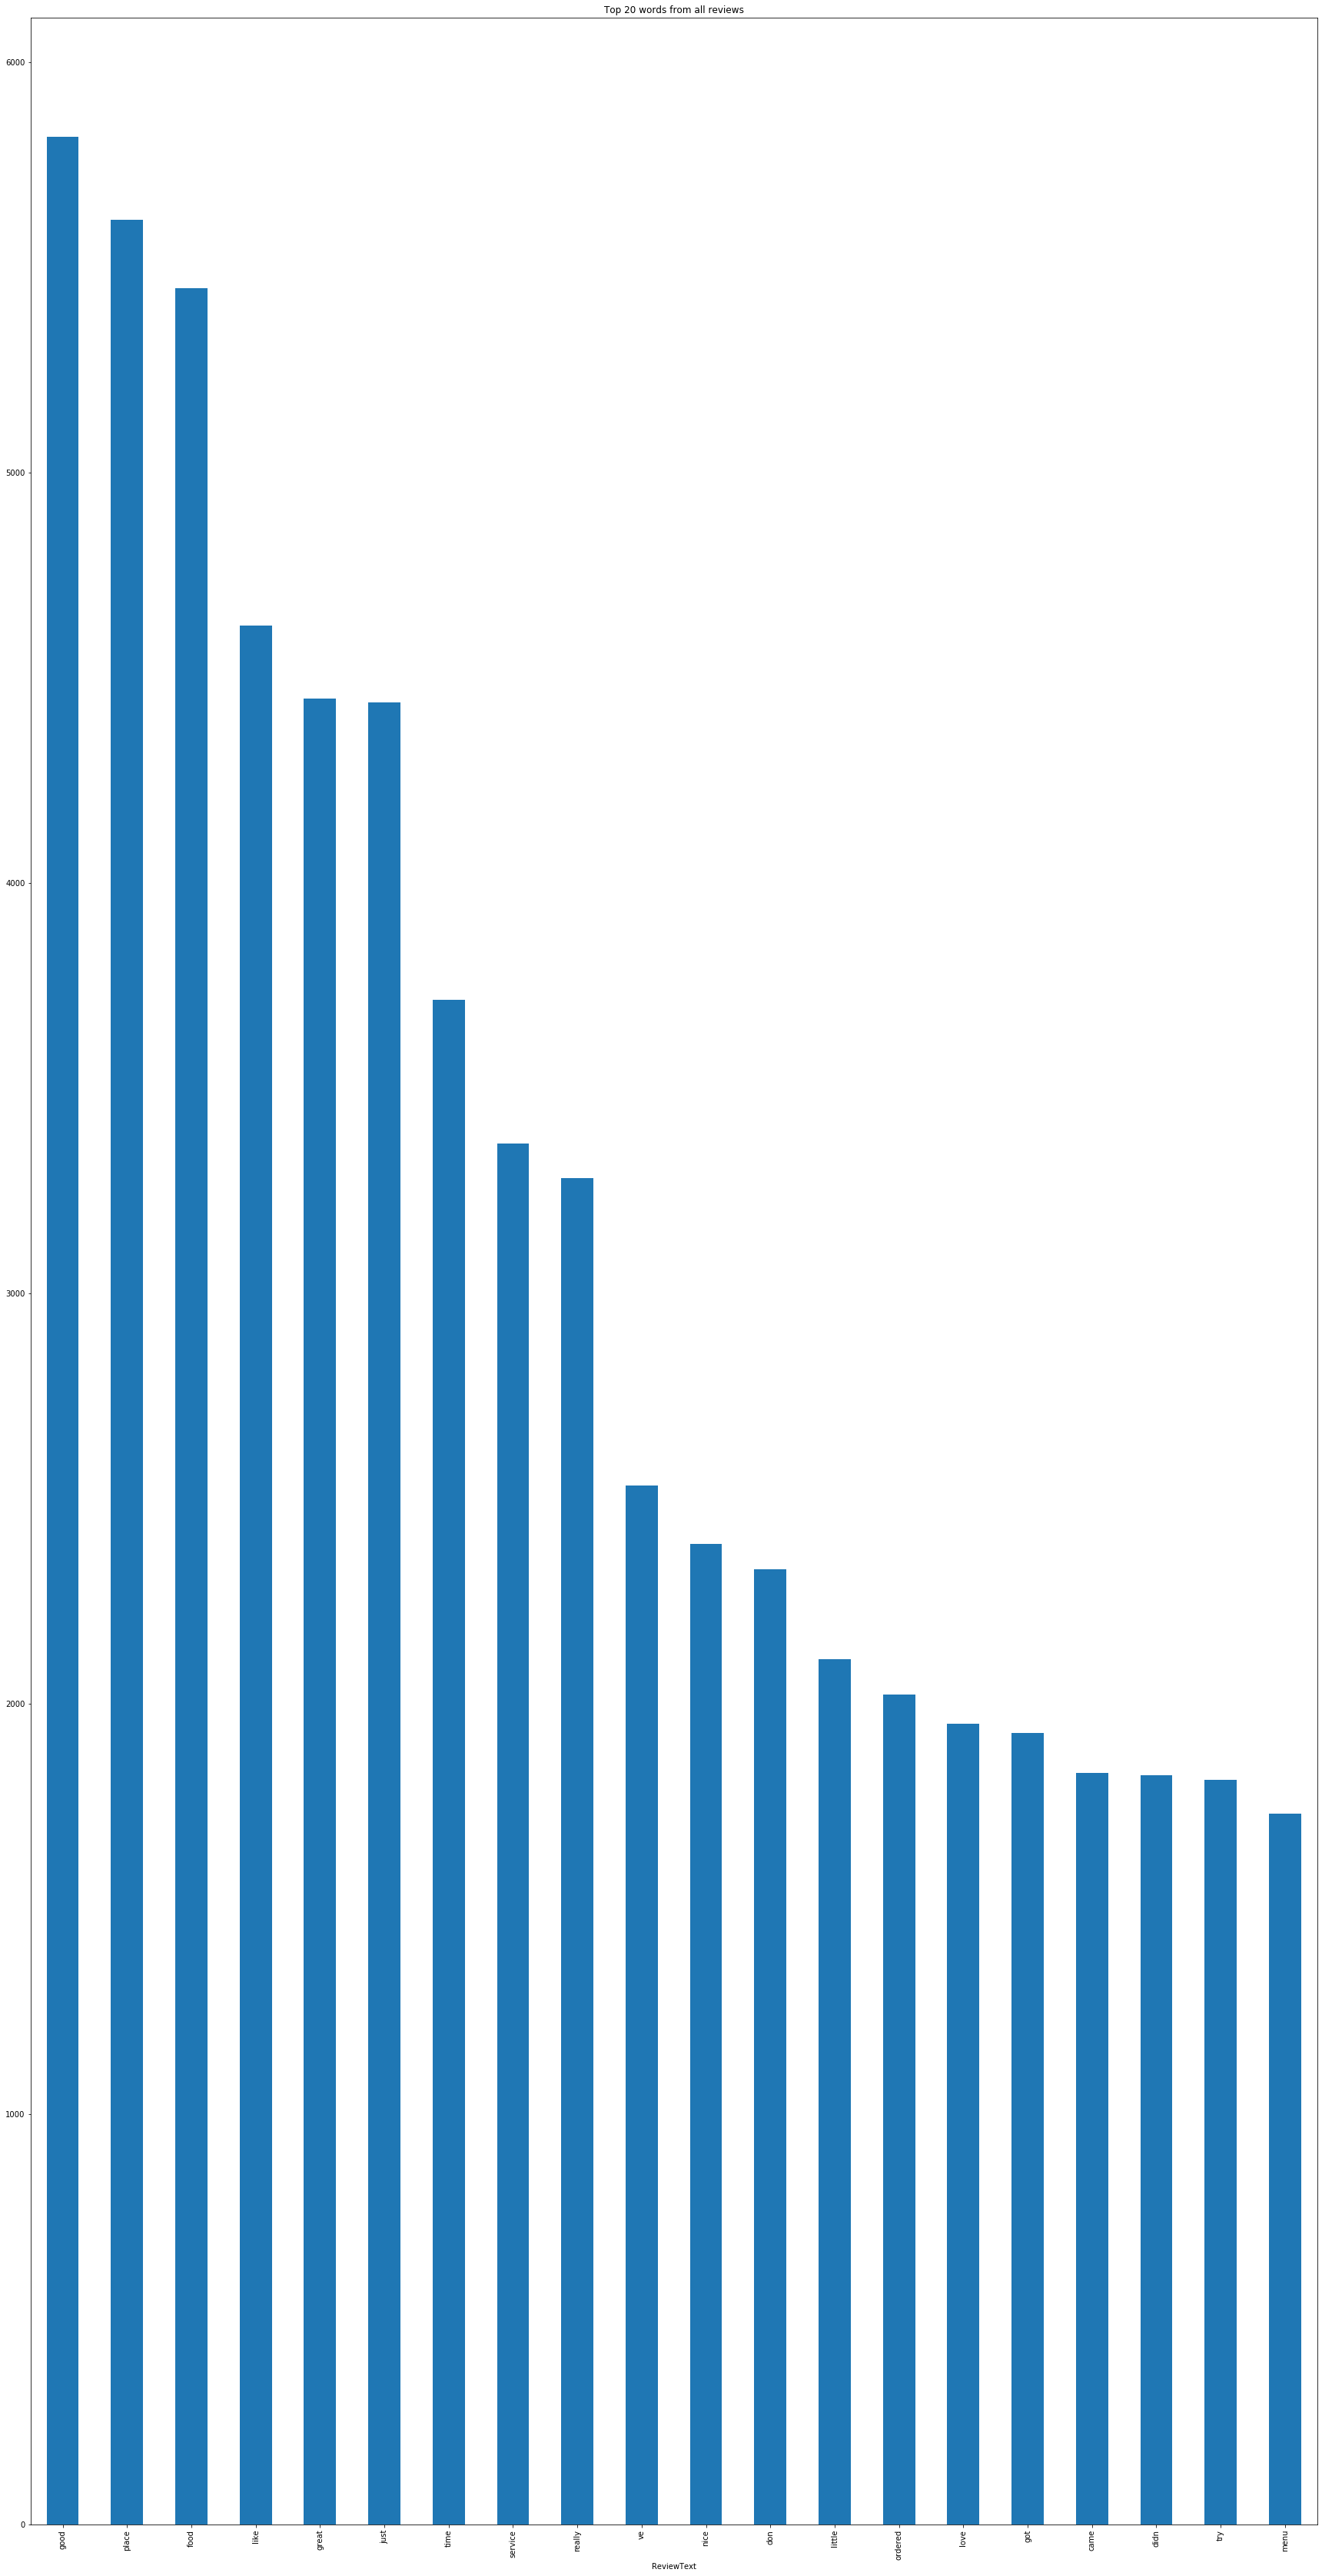

In [31]:
# We start by getting a list of the most common words.

common_words = get_top_n_words(data['text'], 20,1)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='Top 20 words from all reviews')


### Exercise 8:

#### 8.1

Divide the data into "good reviews" (i.e. `stars` rating was greater than 3) and "bad reviews" (i.e. `stars` rating was less than 3) and make a bar plot of the top 20 words in each case. Are these results different from above?

**Answer.** One possible solution is shown here:

good 3602
place 3502
great 3492
food 3043
like 2485
just 2356
time 2284
really 1997
service 1947
ve 1650
nice 1590
love 1548
little 1330
don 1253
delicious 1231
friendly 1226
best 1214
definitely 1176
staff 1126
try 1123


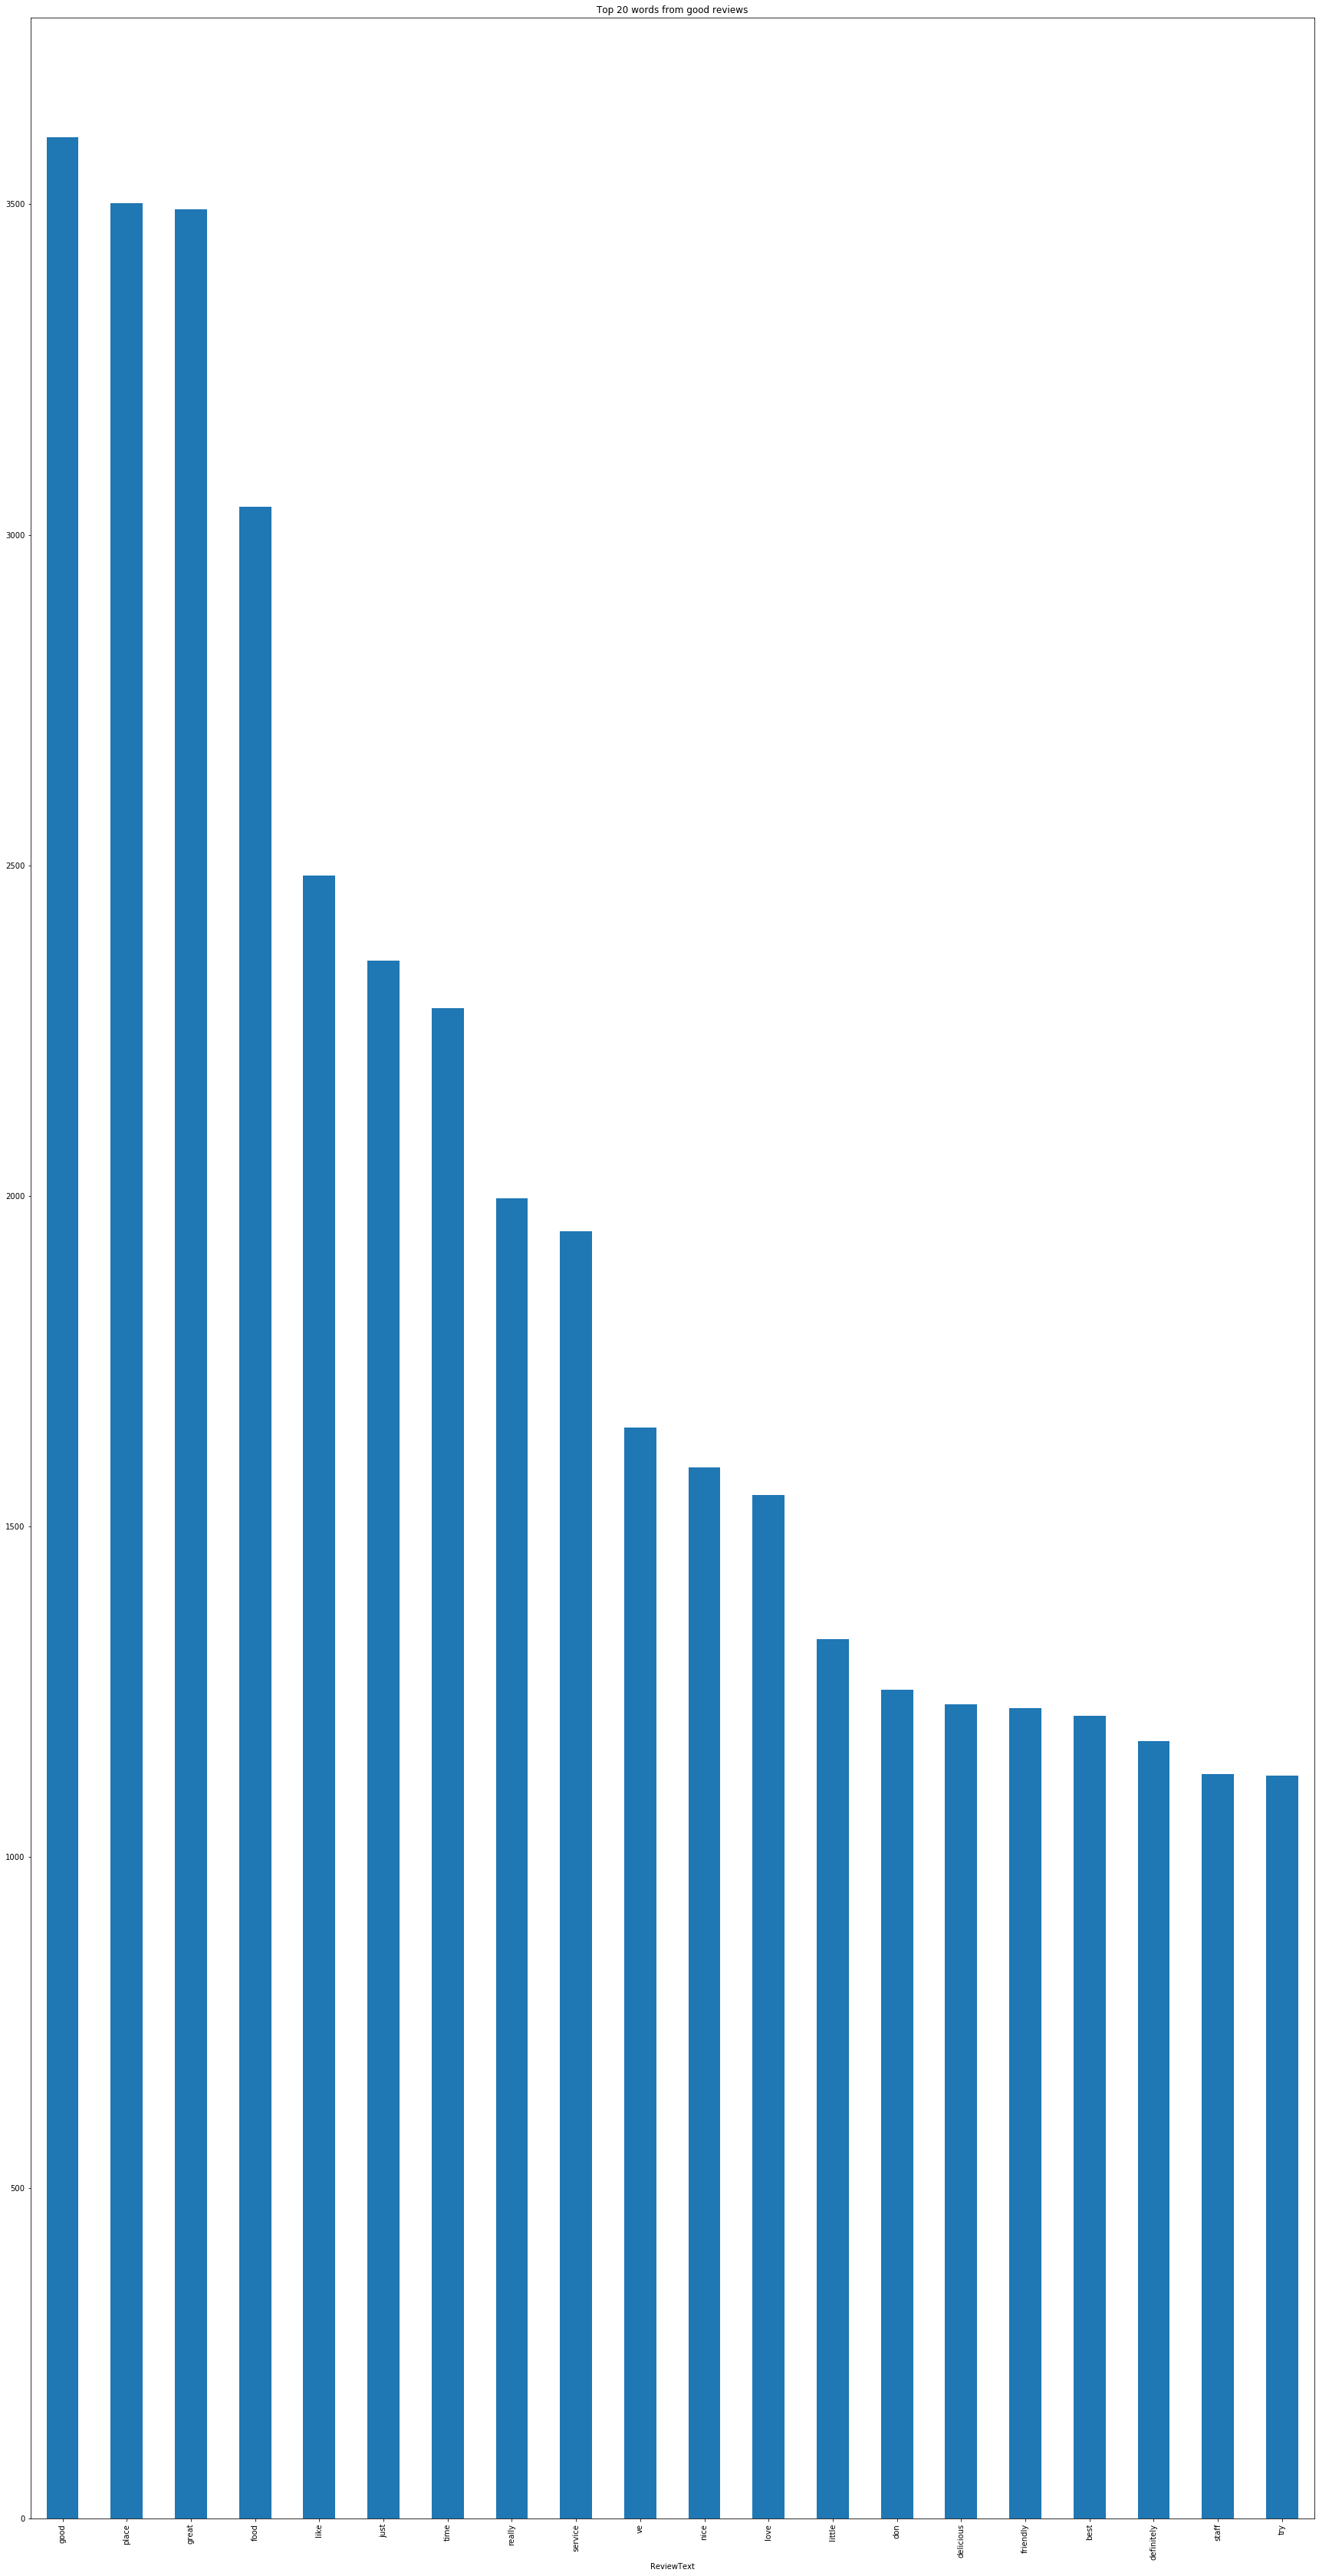

In [32]:
# We continue by splitting according to good/bad review scores, then grabbing again.

GoodInd = data['stars'] >3.1
GoodRev = data[GoodInd]
BadInd = data['stars'] <2.1
BadRev = data[BadInd]

common_words = get_top_n_words(GoodRev['text'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from good reviews')

food 1252
just 1168
place 1122
like 1040
good 829
service 808
time 793
didn 561
really 559
don 556
got 529
said 524
did 515
ordered 502
order 494
came 467
minutes 438
ve 434
told 424
people 423


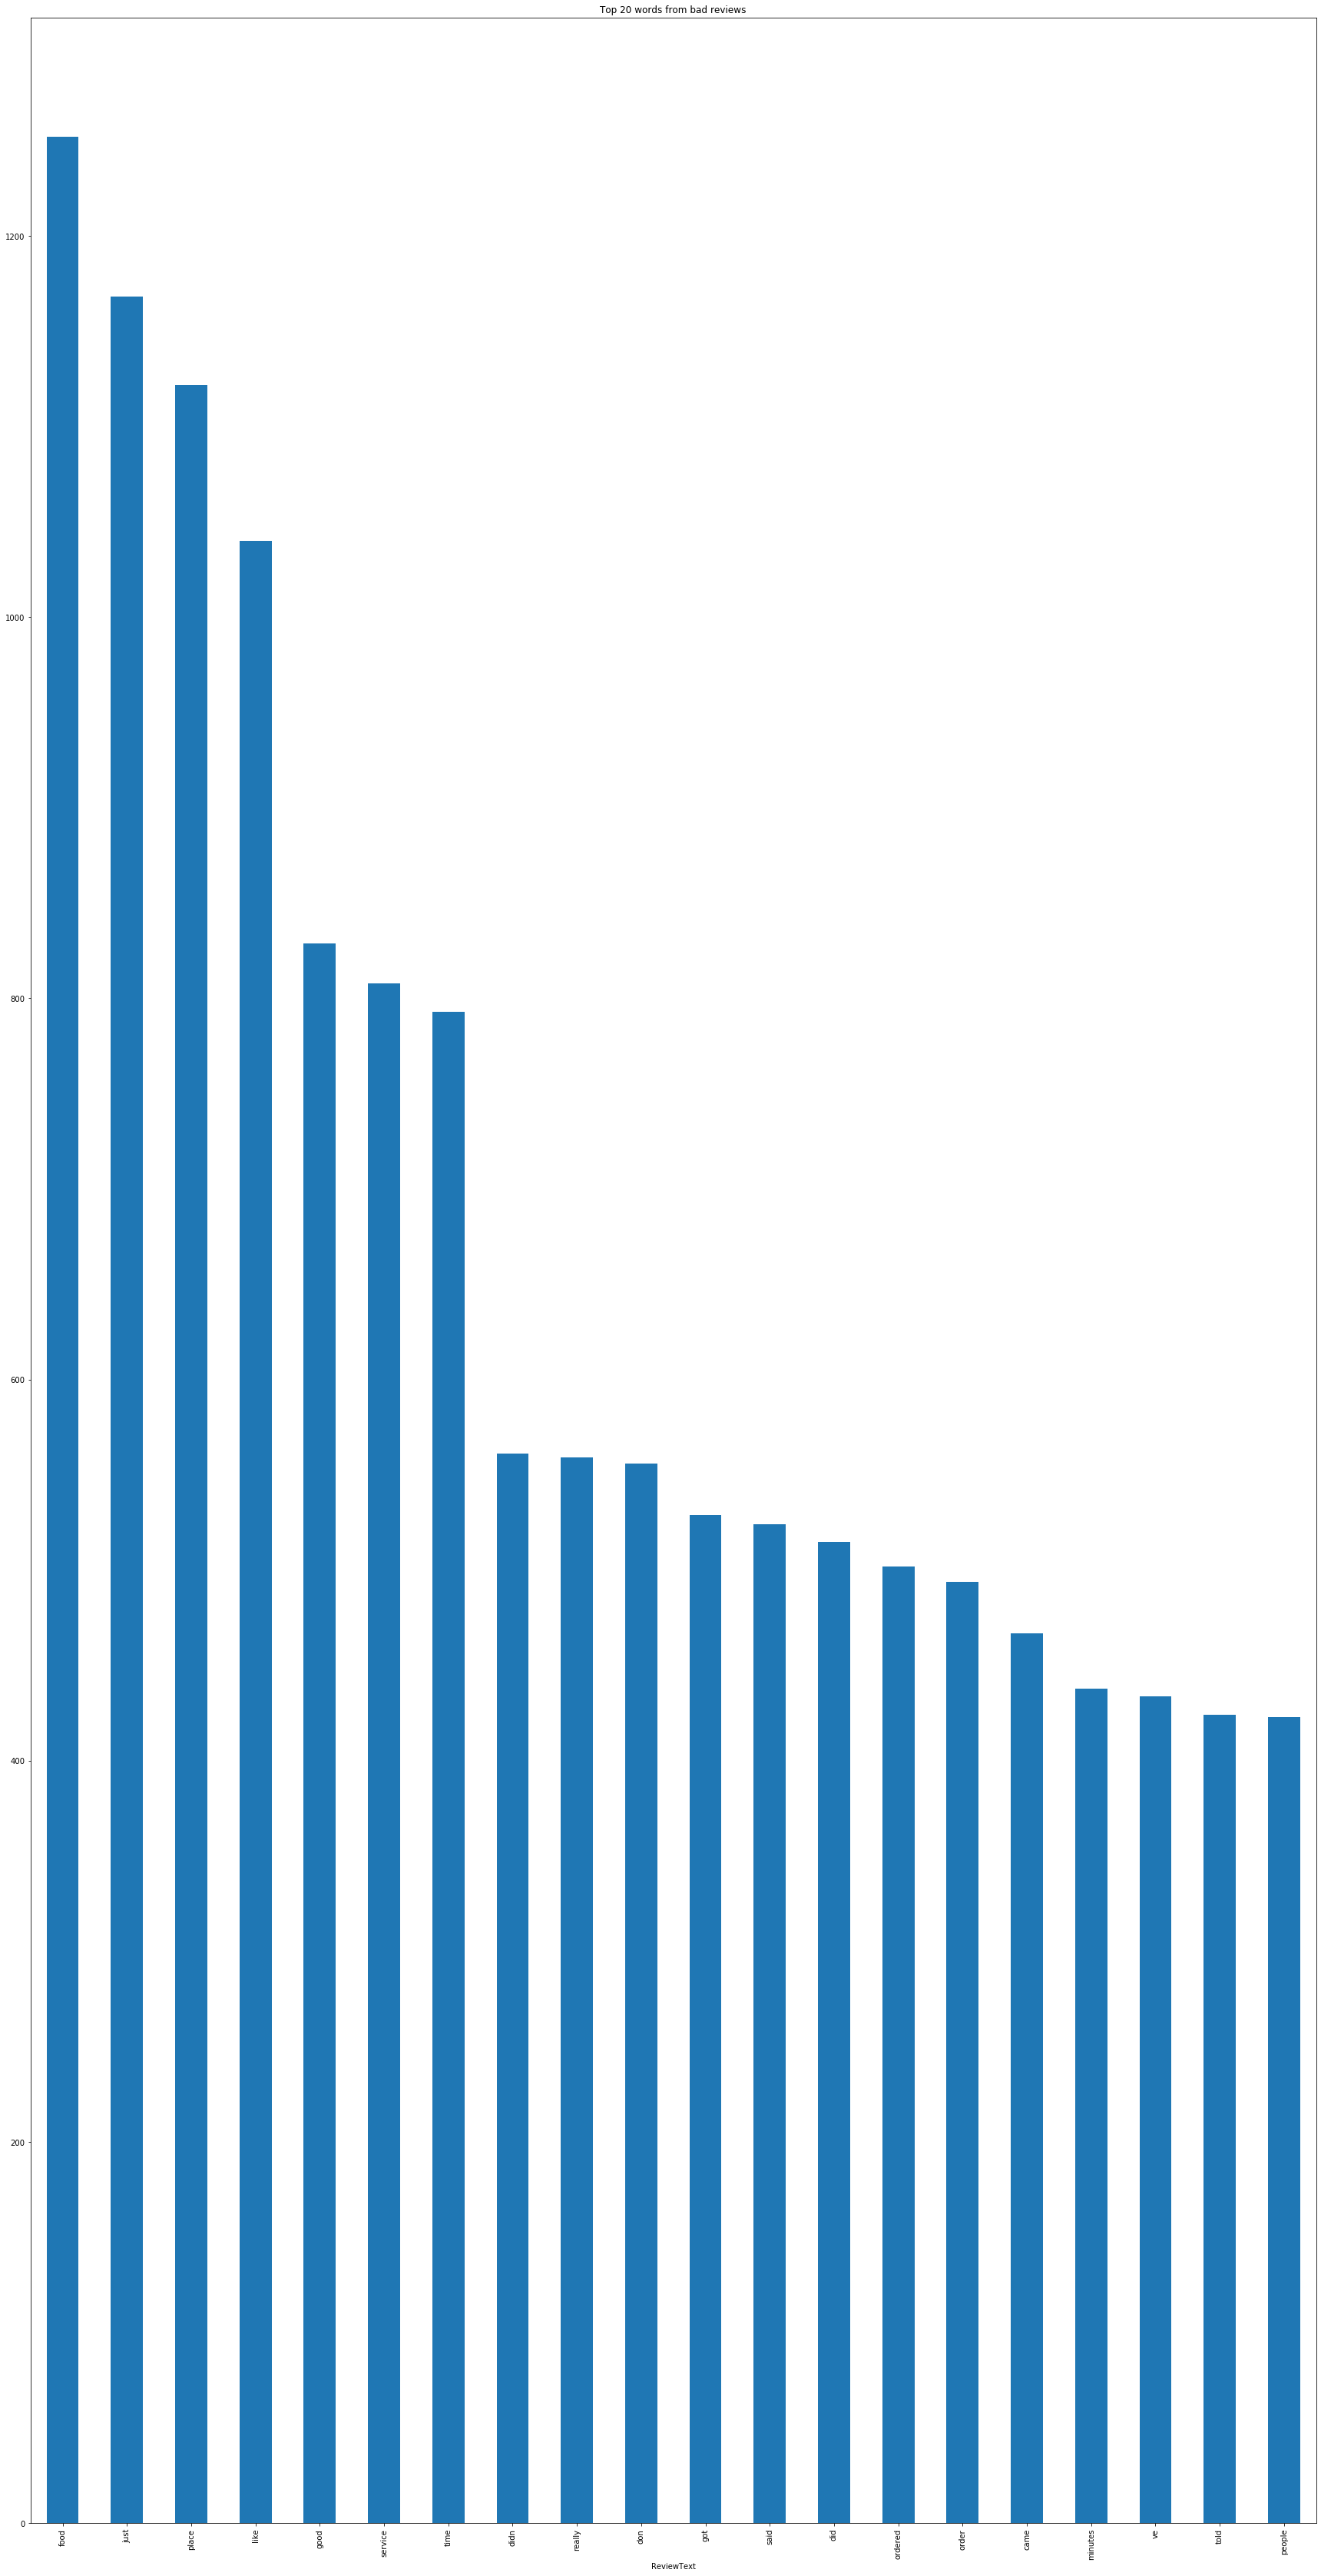

In [33]:
common_words = get_top_n_words(BadRev['text'], 20)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words from bad reviews')

Well, that was pretty useless. The "good" words are mostly a mix of generic words like "place" and overtly positive words like "good" itself.

The problem here is that we are dealing with single words, which cannot convey much information out of context. The natural solution then is to deal with n-grams, so that we can get context-aware results like "good burger" or "good service" (in the positive reviews) or, as we saw, "good 45 minutes" (in the negative reviews).

#### 8.2

Use the `get_top_n_words()` function to find the top 20 bigrams and trigrams. Do the results seem useful?

**Answer.** One possible solution is shown here:

customer service 163
don know 83
20 minutes 61
10 minutes 60
tasted like 59
15 minutes 56
feel like 55
looked like 51
ice cream 47
make sure 45
happy hour 45
pretty good 42
didn want 41
minutes later 41
don think 41
food good 39
30 minutes 36
felt like 33
food just 31
place just 30


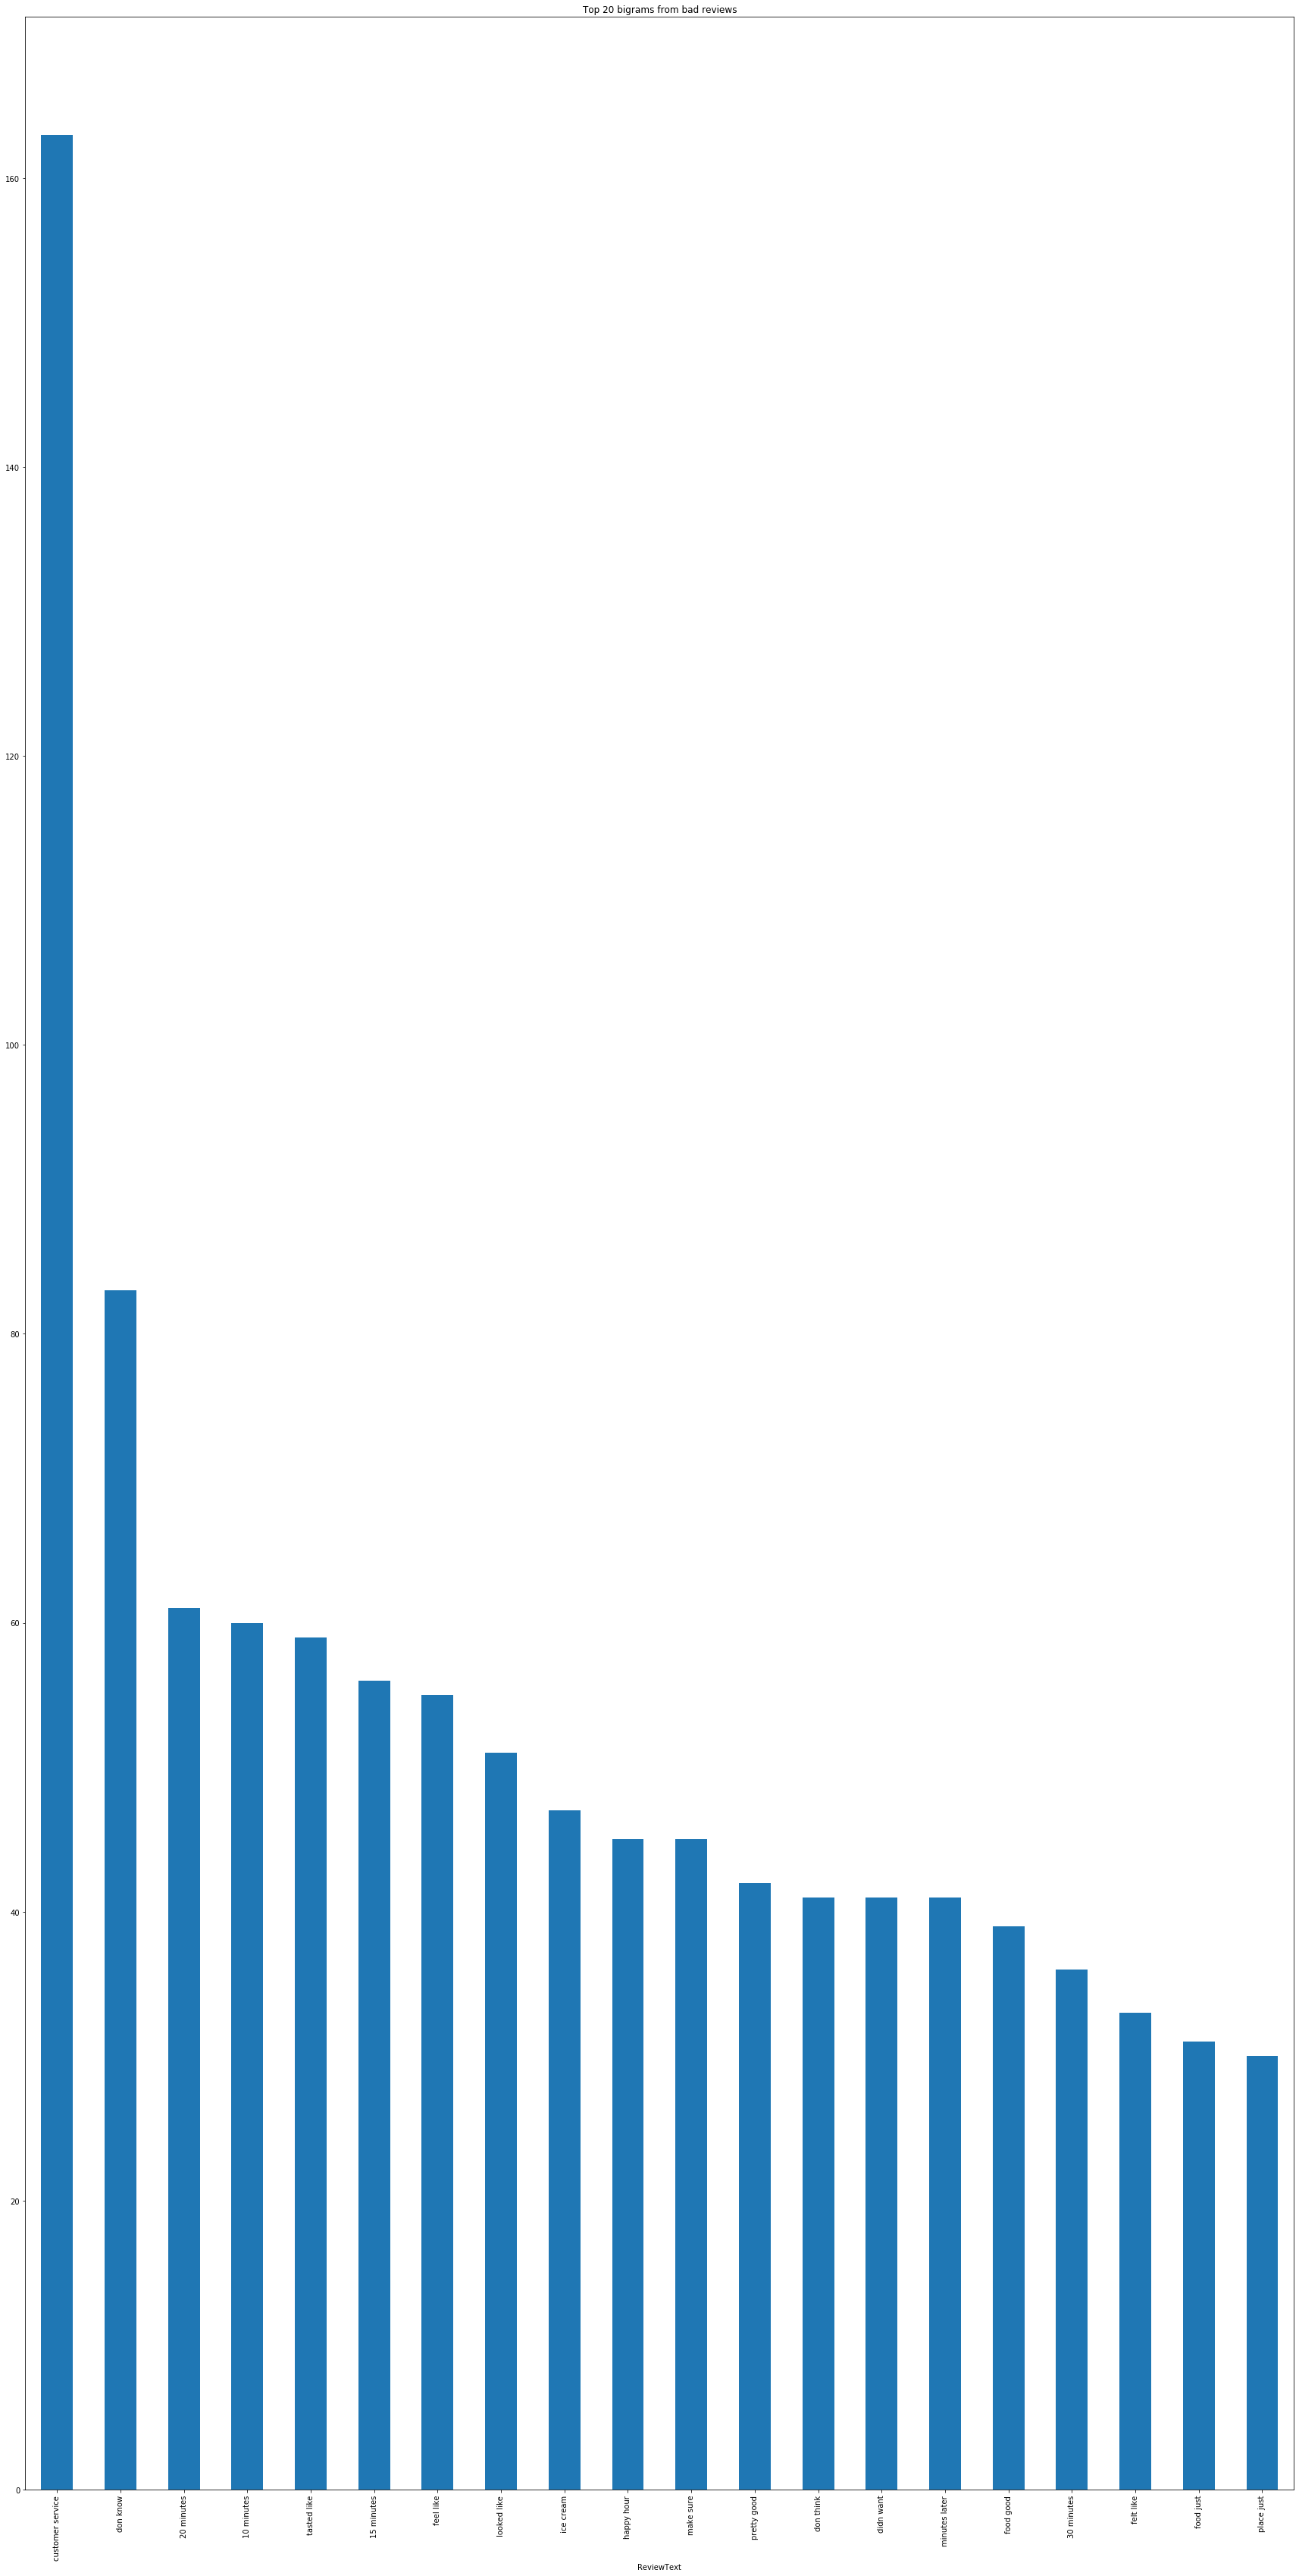

In [38]:
# Get top bigrams and trigrams from bad reviews
common_words = get_top_n_words(BadRev['text'], 20,2)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams from bad reviews')

worst customer service 9
took 10 minutes 9
wanted like place 8
warning warning warning 8
don waste time 7
waste time money 7
let just say 7
seated right away 7
ve experienced better 7
ce est pas 7
really wanted like 7
10 minutes later 7
horrible customer service 6
vanilla ice cream 6
meh ve experienced 6
french onion soup 6
took 20 minutes 6
qu il avait 6
asked speak manager 6
15 20 minutes 6


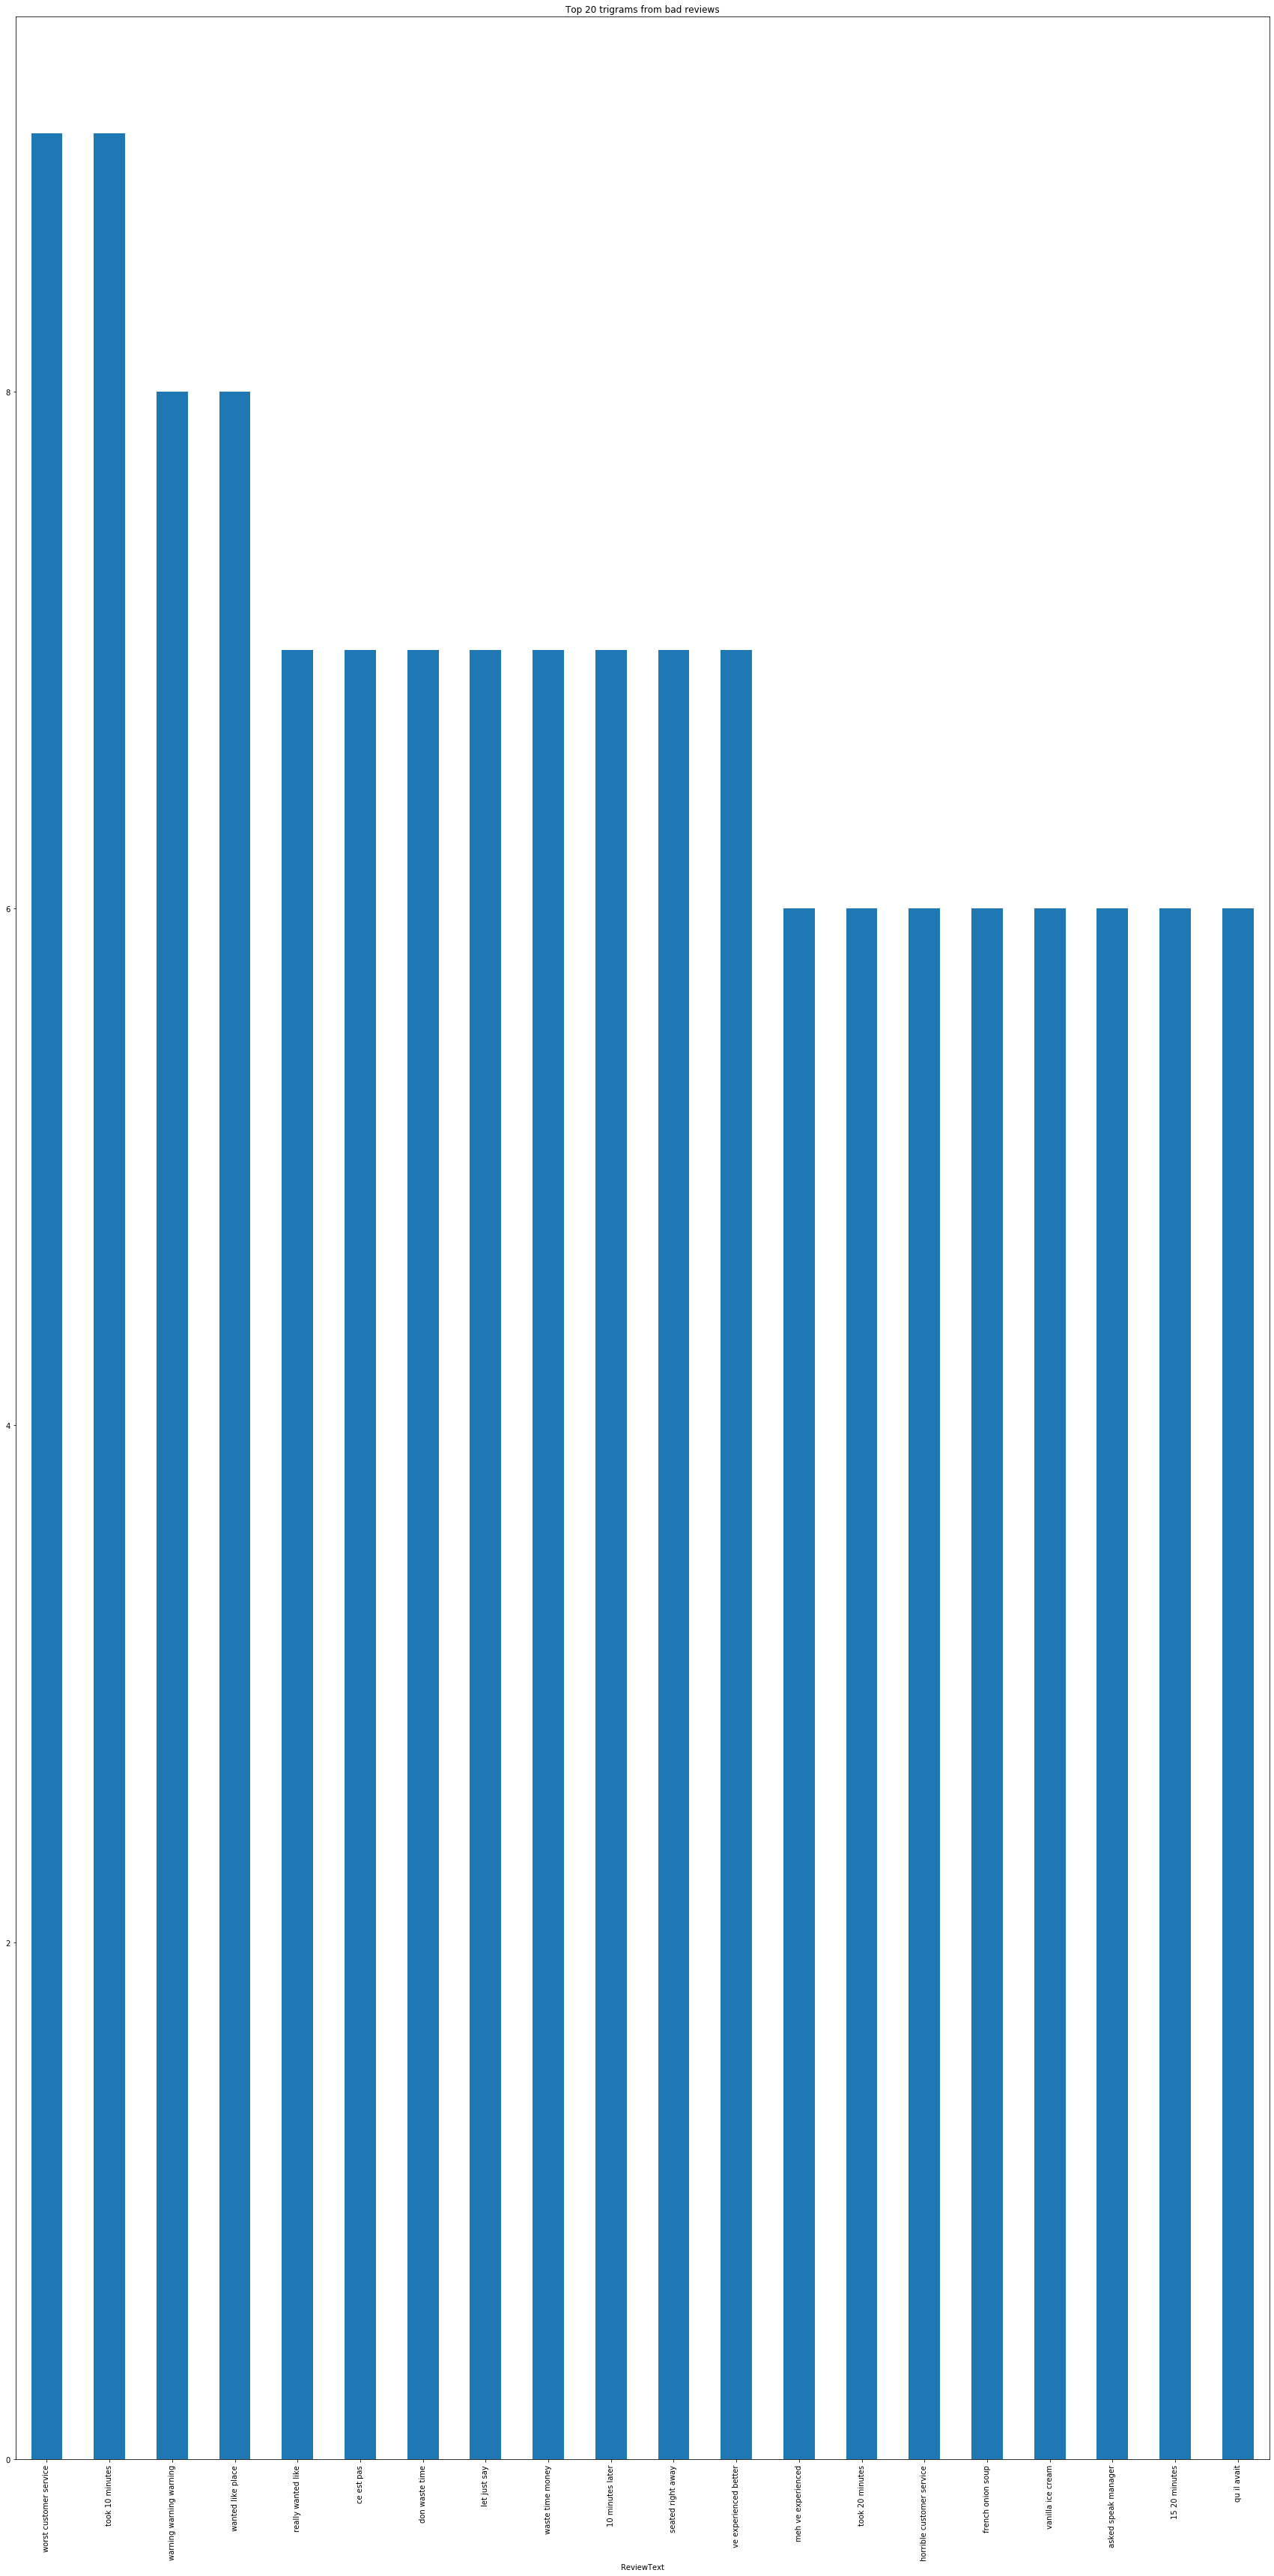

In [39]:
common_words = get_top_n_words(BadRev['text'], 20,3)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams from bad reviews')

really good 264
highly recommend 261
ice cream 219
las vegas 213
customer service 210
great place 203
make sure 200
love place 191
happy hour 188
staff friendly 182
great service 170
pretty good 161
feel like 161
service great 150
great food 148
food good 136
good food 131
don know 127
food great 117
really nice 112


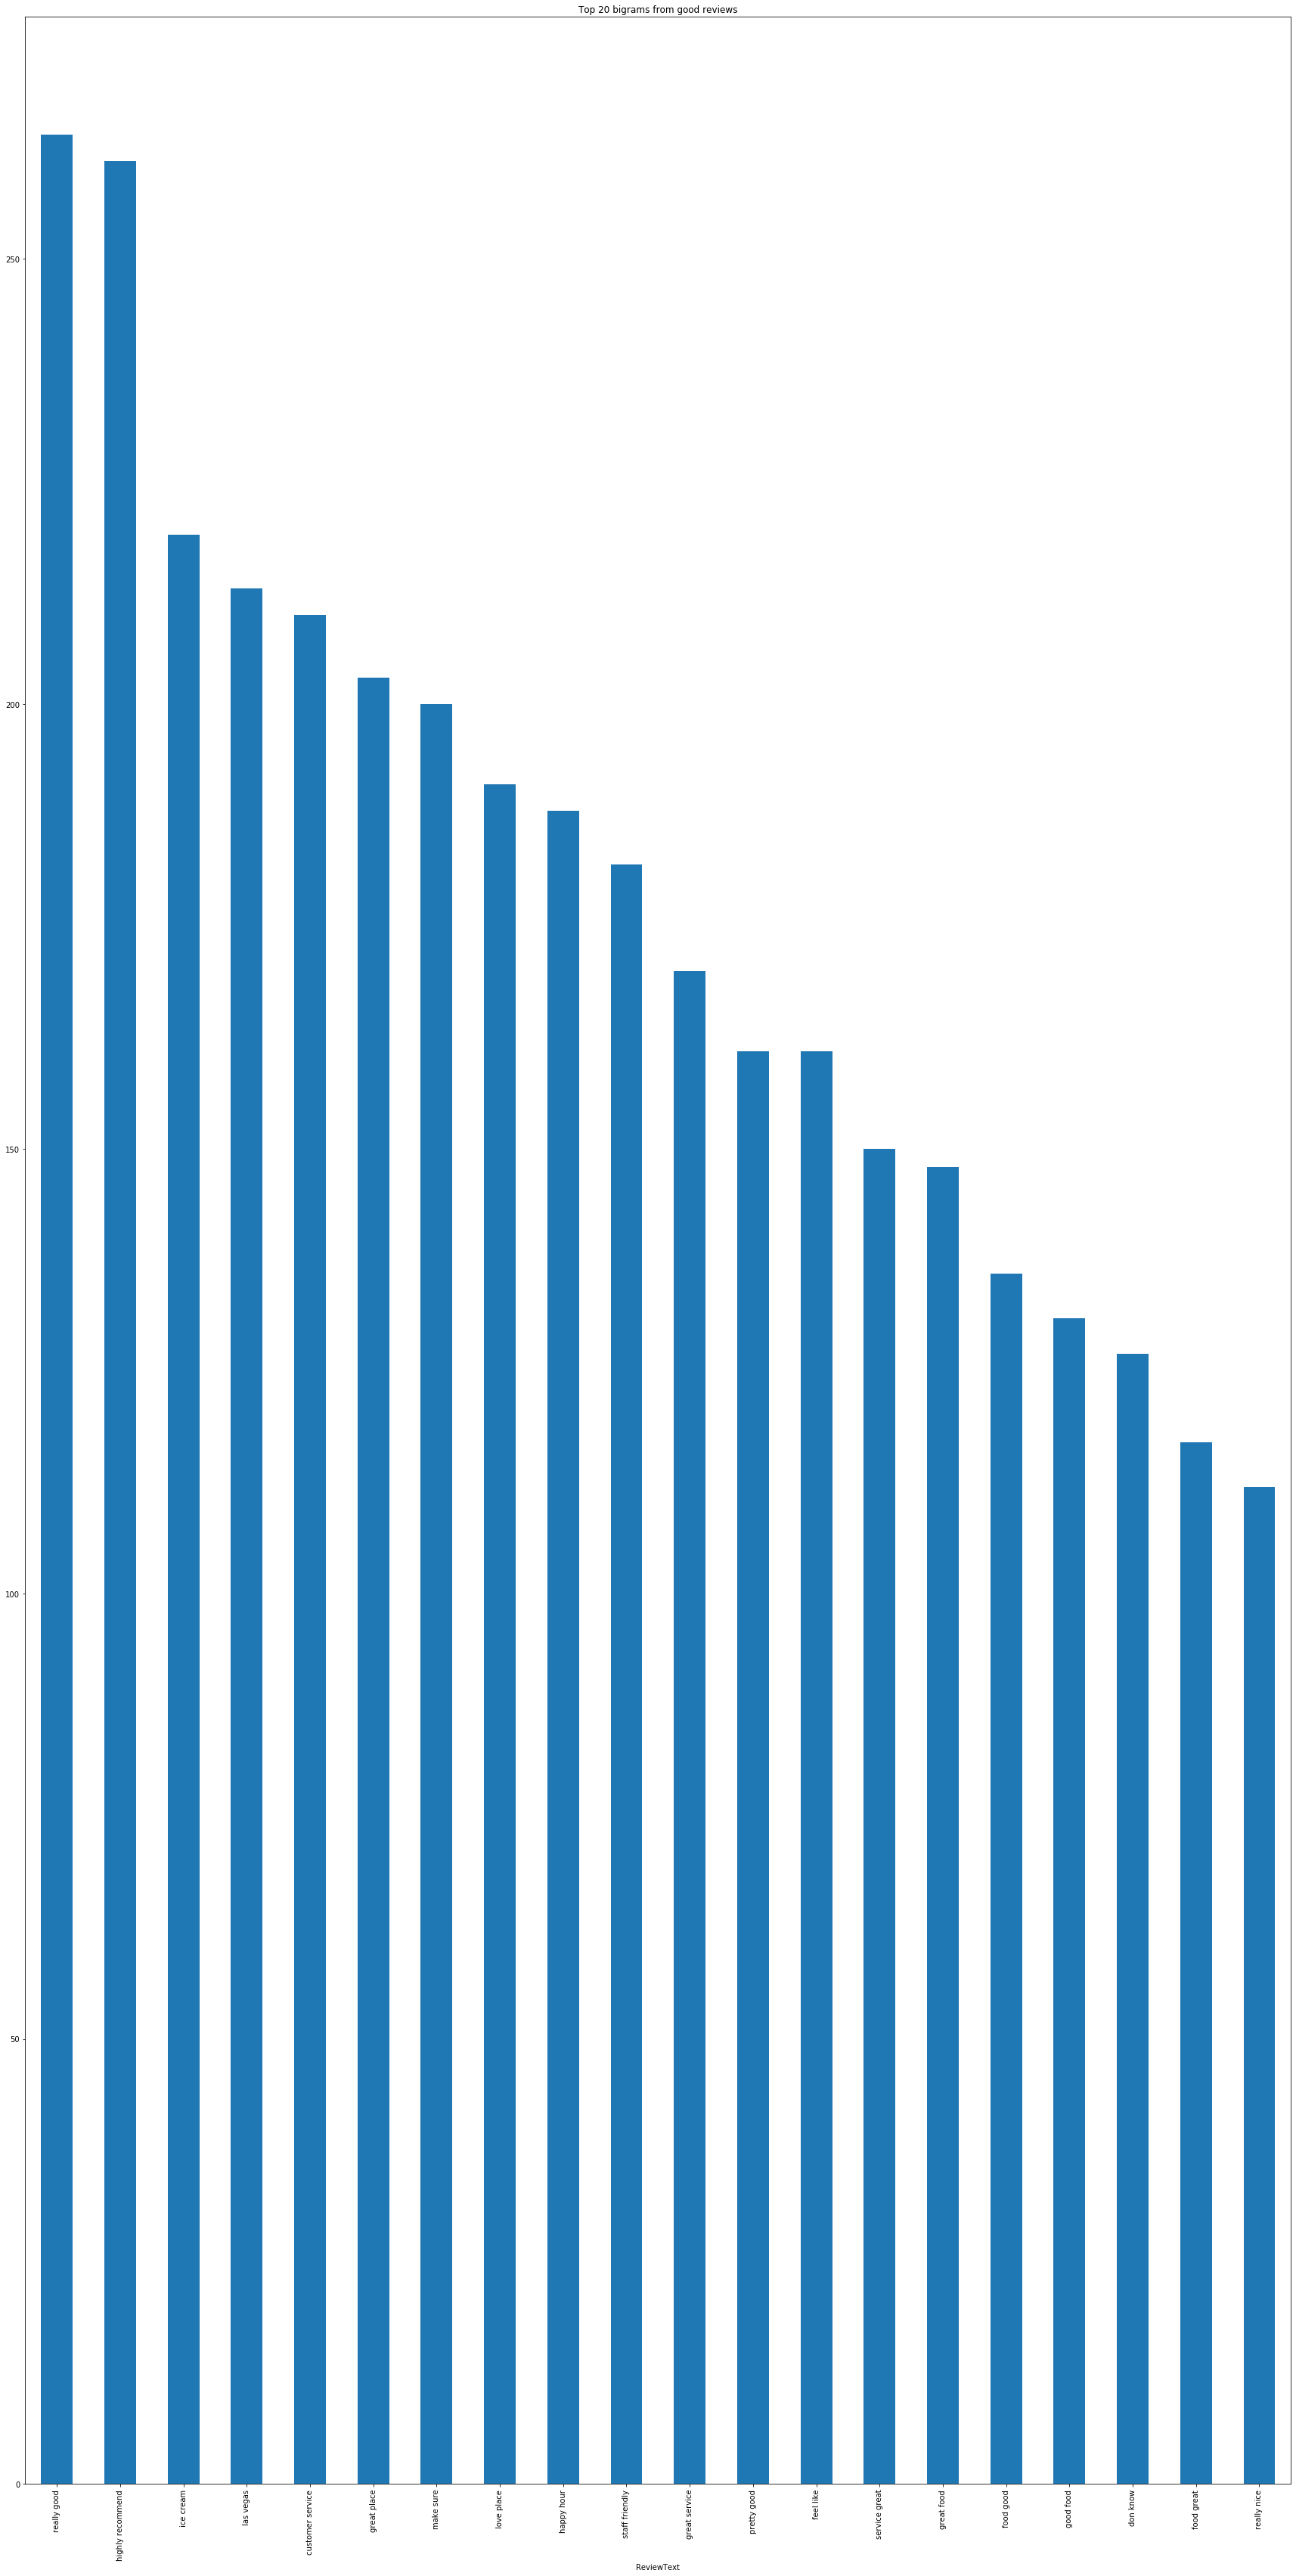

In [40]:
common_words = get_top_n_words(GoodRev['text'], 20,2)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 bigrams from good reviews')

http www yelp 86
www yelp com 86
yelp com biz_photos 84
great customer service 40
did great job 37
sweet potato fries 32
staff friendly helpful 27
food really good 27
service great food 26
highly recommend place 25
love love love 24
great service great 22
staff super friendly 21
definitely recommend place 20
food great service 20
let just say 19
com biz_photos xnjeadlrlj9azb8qsdir2q 19
biz_photos xnjeadlrlj9azb8qsdir2q select 19
make feel like 18
com biz_photos mudalytuatnzm2k9zoh27q 17


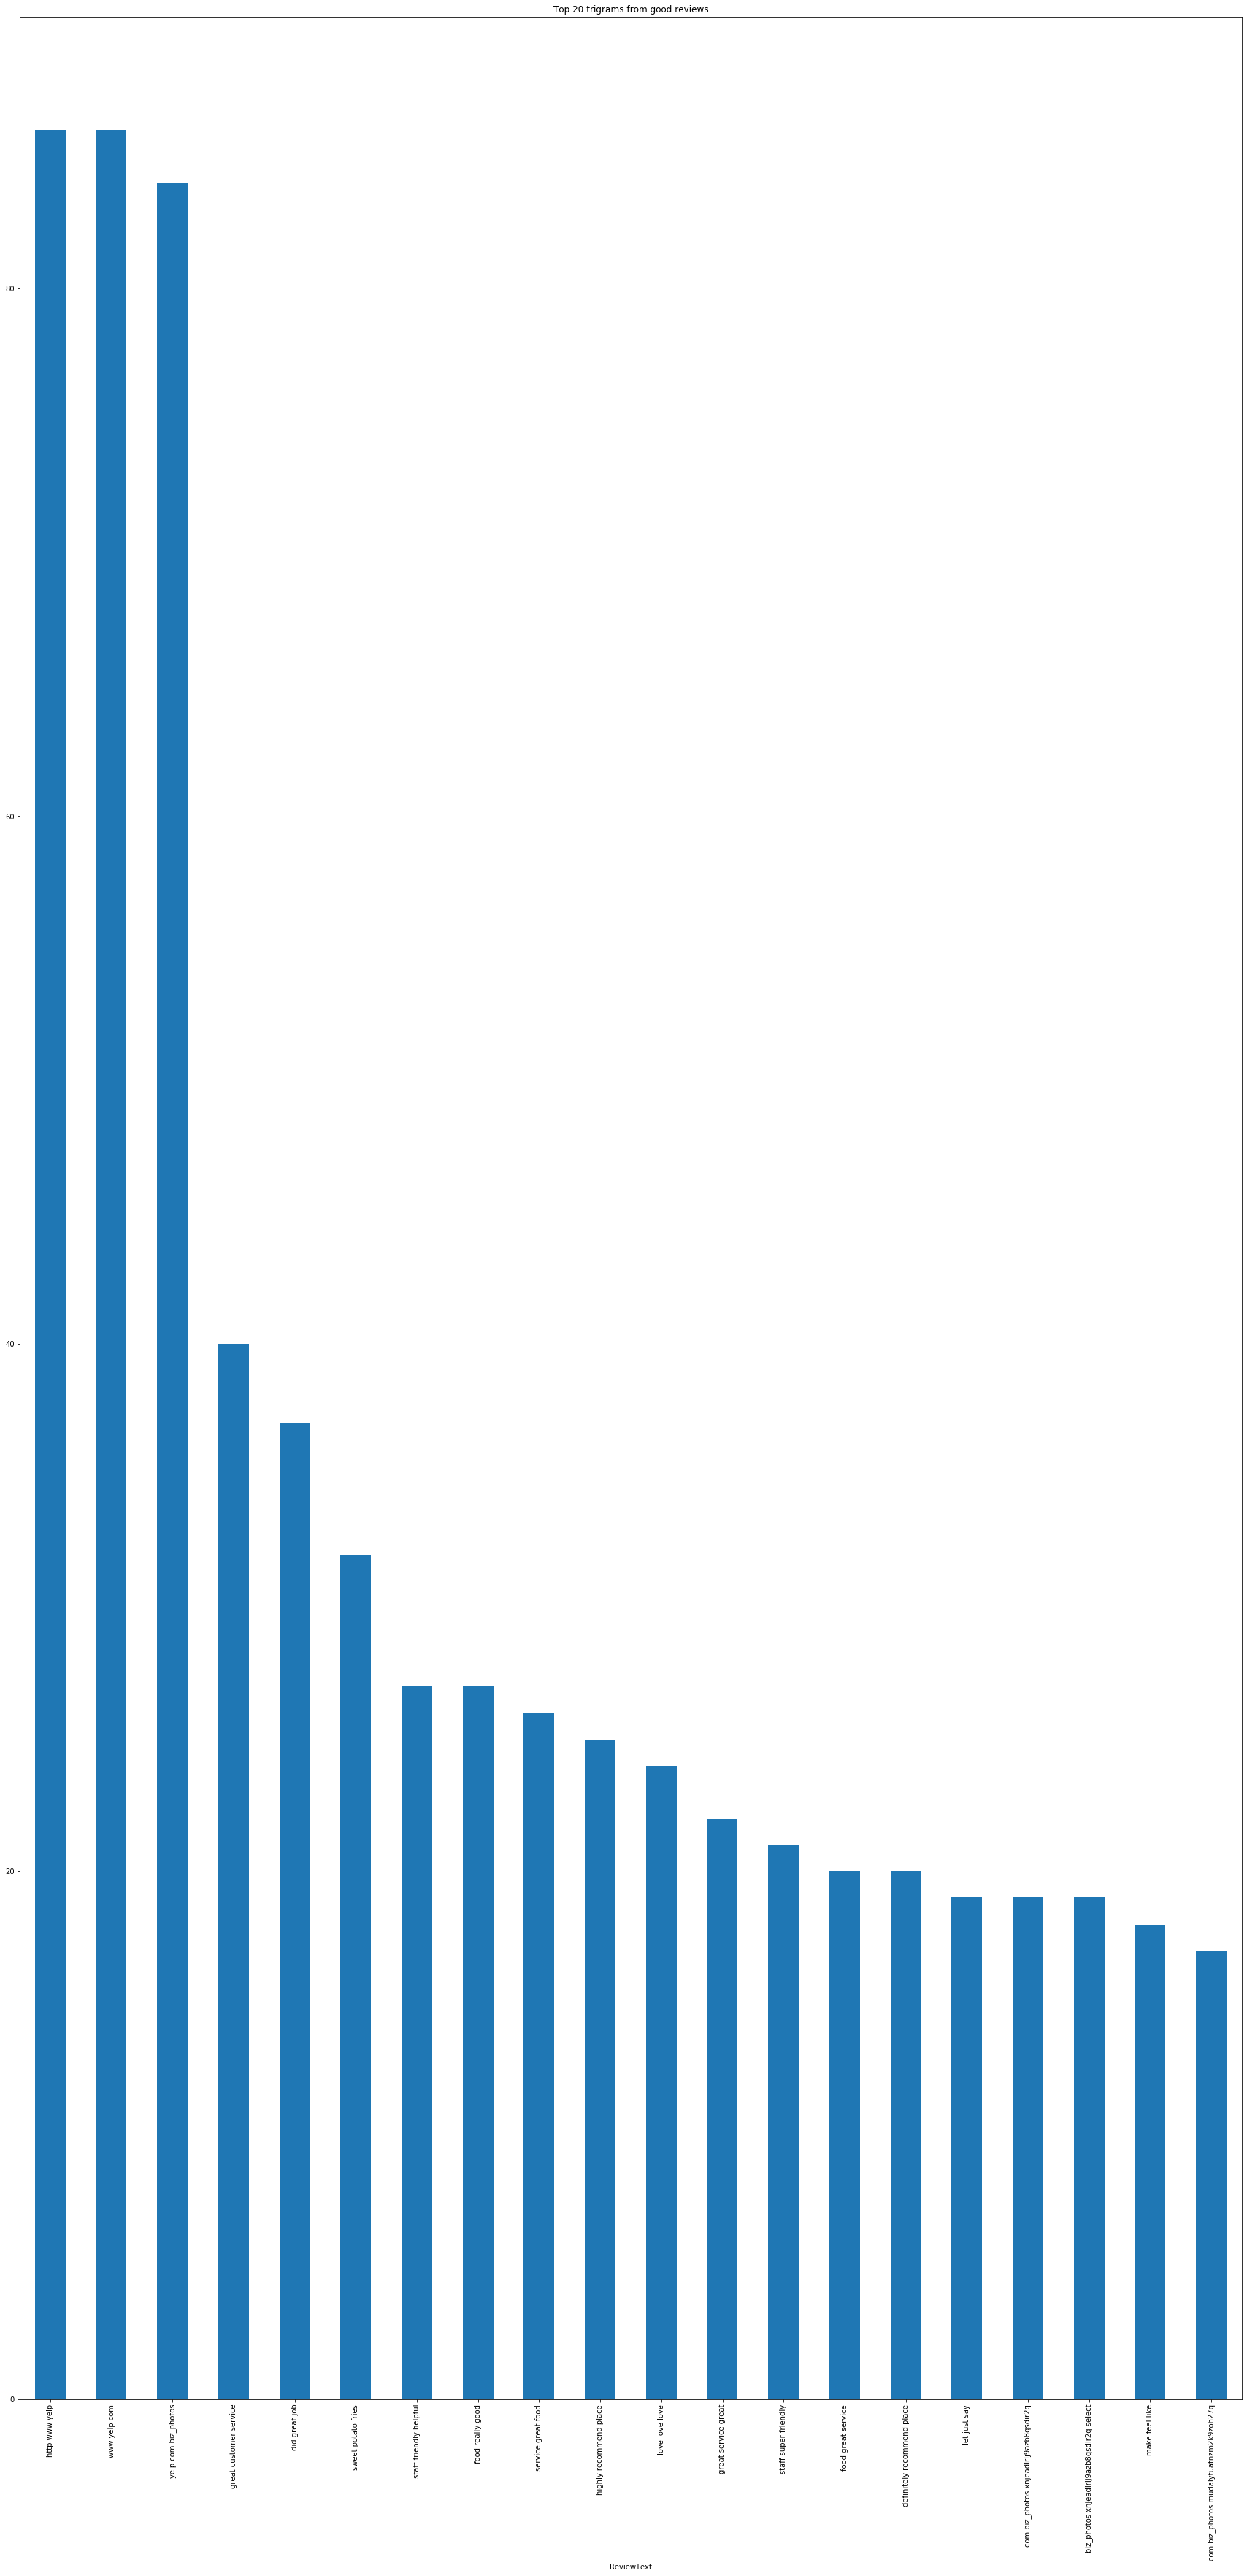

In [41]:
common_words = get_top_n_words(GoodRev['text'], 20,3)
for word, freq in common_words:
    print(word, freq)
df = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 trigrams from good reviews')

Although there are some nonsense entries, this is starting to be helpful. We can see a few recurring themes among good reviews (e.g. "staff friendly helpful"). Nonsense entries are typically difficult to eliminate completely in NLP with user-generated text and smaller corpora. NLP is still useful *despite* the existence of nonsense results, and we should think of the output of NLP algorithms like this as a *screening tool* for finding important phrases rather than a *careful estimate* of the most important phrases. In other words, it's an application of machine intelligence to *conduct exploratory analysis* rather than to *build predictive models*.

### Question:

Look at the 5 most important bigrams for bad reviews. What *single, specific* problem seems to be the most important driver of bad reviews?

Three of the top 5 bigrams were "20 minutes", "15 minutes", and "10 minutes." These are all times, *strongly* suggesting that *waiting time for service* is a main driver for bad review scores.

### Exercise 9:

#### 9.1

You may have noticed that many of the important "bad" bigrams included the words "like" or "just" but didn't seem very informative (e.g. "felt like", "food just"). Give some ideas of how to use this sort of observation in future pre-processing of reviews, based on the pre-processing ideas we have already studied.

**Answer.** Two potential answers are (there are many others):

1. Having recognized that these words go together in common bigrams, you could modify your algorithm so that it "clumps" these bigrams together; i.e. treats them as one word, so that your algorithm will focus on the words following that.
2. Having recognized this as a key phrase, we could have a list of the most important words that follow these key phrases (which are presumably informative). This is more time-consuming as it requires human input.

#### 9.2

Building on the previous question, we note that most of the most important complaints and compliments can't be *completely* observed by looking at bigrams or trigrams. This can often be fixed by small modifications. Do the following:

1. Write down a complaint that is unlikely to be (completely) picked up by bigram analysis. Hint: what might you write if your hamburger was served cold?
2. Write down a processing step that would fix this problem. Try to find a solution that would work for several similar problems without additional human input.

**Answer.** There are many good answers, but we focus on a simple one:

1. I would probably write "the burger was cold" or "the burger was served cold." If this were a common complaint, the most-important bigrams might include "was cold" or "served cold," which doesn't tell me *what* was served cold.
2. A simple fix, along the lines of the previous question, would be to "clump" words like "was cold" together. However, I think this is a bad fix, as it focuses too much on the word "cold" and would require a great deal of hand tuning. A better idea would be to recognize that words like "was" are always going to be a problem in this context, as they separate the important noun describing the subject ("burger") from the adjective describing the problem ("cold"). This suggests that we should take a *much* more aggressive stance towards removing stop words. This should certainly include conjugations of "to be," and likely many other common but uninformative words (like "too").

This second response is an important takeaway for NLP – this sort of problem is extremely common, and a great deal of time is often spent tweaking initial pre-processing rules. In the final part of this case, you will learn about a method that can help systematically deal with these uninformative stop words.

## Regular Expressions

Having spent a lot of time on n-grams and how to featurize a document using them, we now take a break from `nltk` tools to introduce the most important text wrangling tool in Python (and many other languages): **regular expressions**.

The basic idea here is that you often want to perform some specific transformation (e.g. delete or substitute) every time that some possibly-complicated pattern (e.g. the letter 'A', the word 'hello', any word containing the letters 'a','r' in that order) occurs. Regular expressions are a compact and powerful language for expressing these sorts of patterns. This is super important whenever you are trying to clean a text dataset that contains thematically similar, but not exactly, the same errors.

In Python, the `re` module provides regular expression matching operations and common operations. Regular expressions are a deep subject, with some documentation here: https://docs.python.org/3/library/re.html?highlight=regex.

As some simple examples, we have:

1. `.` matches any character except \n (newline)
2. `\d` matches any digit (this can also be written as [0-9])
3. `\D` matches any non-digit (this can also be written as [^0-9])
4. `\w` matches any alphanumeric character ([a-zA-Z0-9_])
5. `\W` matches any non-alphanumeric character ([^a-zA-Z0-9_])

As some more complex examples, regular expressions also allow you to quantify the number of times matches can occur. For example,

1. `[a-d]+` matches any time you get $\{a,b,c,d\}$ one or more times in a row
2. `[a-d]{3}` matches any time you get them exactly 3 times in a row
3. `[a-d]*` matches any time you get them 0 or more times in a row

For now, we give a simple application based on the  `re.sub()` function, which substitutes words that match a pattern:

In [42]:
import re
sentence = 'That was an "interesting" way to cook bread.'
pattern = r"[^\w]" # the ^ character denotes 'not', 
#                   the \w character denotes a word, and []  means
#                    anything that matches anything in the brackets. 
#                     Together, this refers to any character that is not a word.
print(re.sub(pattern, " ", sentence))

That was an  interesting  way to cook bread 


In [43]:
str = "Natesh loves all the foold and loveds sdaslo"
x   = re.compile('lo')
iterator = x.finditer(str)
for item in iterator:
    print(item.span())
    print(item.group())

(7, 9)
lo
(31, 33)
lo
(42, 44)
lo


### Exercise 10:

#### 10.1

1. Use the `re.split()` function to split the first Yelp review into a list of its constituent words.
2. Use the `re.findall()` function to search the first 30 reviews for the number of times they contain the word "food". Print the maximum number of times the word "food" is mentioned in a single review.

**Answer.** One possible solution is shown below:

In [44]:
re.split(r'\s', AllReviews.values[0])

['Super',
 'simple',
 'place',
 'but',
 'amazing',
 'nonetheless.',
 "It's",
 'been',
 'around',
 'since',
 'the',
 "30's",
 'and',
 'they',
 'still',
 'serve',
 'the',
 'same',
 'thing',
 'they',
 'started',
 'with:',
 'a',
 'bologna',
 'and',
 'salami',
 'sandwich',
 'with',
 'mustard.',
 '',
 '',
 'Staff',
 'was',
 'very',
 'helpful',
 'and',
 'friendly.']

In [45]:
food_count = []
for sentence in AllReviews.values:
    temp = len(re.findall('food', sentence))
    food_count.append(temp)
print(max(food_count[0:30]))

2


#### 10.2

Using regular expressions, find the percentage of reviews in top 500 reviews that have numbers in them.

**Answer.** One possible solution is given below:

In [46]:
### Considering the top 500 reviews for this analysis
top_500_reviews = AllReviews.values[:500]
reviews_nos_regex = []

for each_review in top_500_reviews:
    number_list = re.findall('\d',each_review)
    
    ## number list returns all the possible digits in a review
    ## Look if the number list is empty - if so, the review has no digits in them
    if(len(number_list)) > 0:
        reviews_nos_regex.append(each_review)

In [47]:
len(reviews_nos_regex)/len(top_500_reviews)

0.326

As is clear from above, regular expressions are very useful for extracting more general properties of text. These properties are not as informative or context-aware as n-grams can be, but they are much simpler to code and therefore can often serve as the first step of an EDA on text data.

Although regular expressions usually cannot tell us much about context overall, they *can* be used to find specific instances of words in context. For example, we may be interested in finding the first word following "good" or "bad" in a review (which can help us distinguish a positive from a negative review). Let's write some code that finds the first word following "good" in the sentence "hello I want a good burger, please.":

In [48]:
sample = "hello I want a good burger, please"

# Find everything after "good", including "good"

post = re.findall(r'good.*', sample)[0]

print(post)

# Take just the first word after "good"

first_post = re.split(r'\s',post)[1]

print(first_post)

good burger, please
burger,


#### 10.3

Using the above as a template, write a generalized function that can extract the first word following "good". Don't forget to include a default behavior for when the word doesn't appear in the sentence. Run this function for all reviews and print the first 300 results for reviews that do contain the word "good".

**Answer.** One possible solution is given below:

In [49]:
def next_word(sentence):
    post = re.findall(r'good.*', sentence)
    if (len(post) > 0):
        temp = re.split(r'\s',post[0])
        if (len(temp) > 1):
            return(temp[1])
        else:
            return('')
    else:
        return('')
    
    
print(next_word(sample))


burger,


In [50]:
post_good = []
ind = 0
for sentence in AllReviews.values:
    temp = next_word(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
print(nonempty[0:300])

['Burgers', 'bully', 'The', 'burgers', 'things', 'Too', 'size', 'they', '45', 'Soft', '-', 'and', 'and', 'for', 'Hot', 'for', 'Price', 'for', 'really', 'ramen.', 'First', 'The', 'size', 'Definitely', '-', 'I', 'as', 'deal!', 'with', 'in', 'price', 'as', 'food', 'What', 'to', 'Finally,', 'actually.', 'The', 'but', 'experiences', 'and', 'however', 'if', 'so', '(she', 'experiences', 'experiences', 'size', 'experience', 'This', 'My', 'but', 'at', 'Mexican', '(for', 'and', 'the', 'ones,', 'but', 'My', 'I', 'The', 'but', 'but', 'food', 'size', "I'm", 'reviews.', "I'd", 'but', 'idea', 'things,', 'The', 'as', 'as', 'good,', 'as', 'But', 'opinions', 'selection', 'so', 'although', 'and', 'little', 'pulled', 'time', 'Crispy', 'reviews,', 'reviews', 'Mexican', 'service', 'reviews.', 'is', 'and', 'to.', 'directions', 'service.', 'and', 'french', 'part', 'for', 'He', 'Besides', 'and', 'and', 'experience.', 'time.', 'burger!', 'and', 'work', 'and', 'But', 'thing.', 'sign.', 'time.', 'I', 'in', 'so', 

Skimming over the results of the previous exercise, a few things stood out:

1. People like to talk about good burgers – this appeared 5 times in the first 300 results.
2. A large number of the results are useless. One common problem is the occurrence of a sentence boundary; e.g. "good. The" near the start of the list. In this case, we should look *before* the word "good" rather than after. However, we can't look *immediately* before good – that word will usually be some conjugation of "to be", which is also not informative – rather, we need to look for a word before "good" that isn't too boring. Other times, there is a word following "good" that is uninformative; e.g. "good for" – we want to know *what* something was good for! In this case, we should keep on skimming *forward* until we see a word following "good" that isn't too boring.

In both of these cases, we can't use simple regular expressions by themselves, as regular expressions don't know how to ignore "boring" words. Regular expressions can only help us filter for the structure of words, not the content they convey within a context. We *can* use what we learned about stop words to remove these from the reviews before conducting the above analysis, but as we have been, we will still sometimes get not very informative phrases like "was cold" or "served cold". So we will introduce an alternative method, which can be applied to serve as an even better remover of stop words: **part-of-speech tagging**.

##  Part-of-speech (POS) tagging

In English, there are eight main parts of speech - `nouns`, `pronouns`, `adjectives`, `verbs`, `adverbs`, `prepositions`, `conjunctions` and `interjections`. These are
`sustantivos`, `pronombres`, `adjetivos`, `verbos`, `adverbios`, `preposiciones`, `conjunciones` and `interjecciones`, respectively, in Spanish. The purpose of POS tagging is to label each word in a document with its part of speech.

Unsurprisingly, POS tagging can be very difficult to do by hand. `nltk` has a default function for this, called `nltk.pos_tag()`, which we will use. As a word of warning, this function is far from infallible, especially on informal text (e.g. website reviews, forum posts, text messages, etc), and words in English often exhibit POS drift (e.g. the drift of "Google" from noun to verb): 

In [51]:
import nltk
nltk.download('averaged_perceptron_tagger')
#https://www.nltk.org/book/ch05.html
text_word_token = nltk.word_tokenize("Natesh is having a good day")
#text_word_token = nltk.word_tokenize(data.text[0])
nltk.pos_tag(text_word_token)
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/haris.jaliawala/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('Natesh', 'NNP'),
 ('is', 'VBZ'),
 ('having', 'VBG'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('day', 'NN')]

In [52]:
text_word_token = nltk.word_tokenize("We are going to Race") # try "Race can be both a verb and a noun"
#text_word_token = nltk.word_tokenize(data.text[0])
nltk.pos_tag(text_word_token)

[('We', 'PRP'), ('are', 'VBP'), ('going', 'VBG'), ('to', 'TO'), ('Race', 'VB')]

In [53]:
#https://www.nltk.org/_modules/nltk/tag/perceptron.html
nltk.pos_tag(words)

[('Super', 'NNP'),
 ('simple', 'JJ'),
 ('place', 'NN'),
 ('but', 'CC'),
 ('amazing', 'JJ'),
 ('nonetheless', 'RB'),
 ('.', '.'),
 ('It', 'PRP'),
 ("'s", 'VBZ'),
 ('been', 'VBN'),
 ('around', 'IN'),
 ('since', 'IN'),
 ('the', 'DT'),
 ('30', 'CD'),
 ("'s", 'POS'),
 ('and', 'CC'),
 ('they', 'PRP'),
 ('still', 'RB'),
 ('serve', 'VBP'),
 ('the', 'DT'),
 ('same', 'JJ'),
 ('thing', 'NN'),
 ('they', 'PRP'),
 ('started', 'VBD'),
 ('with', 'IN'),
 (':', ':'),
 ('a', 'DT'),
 ('bologna', 'NN'),
 ('and', 'CC'),
 ('salami', 'NN'),
 ('sandwich', 'NN'),
 ('with', 'IN'),
 ('mustard', 'NN'),
 ('.', '.'),
 ('Staff', 'NNP'),
 ('was', 'VBD'),
 ('very', 'RB'),
 ('helpful', 'JJ'),
 ('and', 'CC'),
 ('friendly', 'JJ'),
 ('.', '.')]

NLTK provides documentation for each tag, which can be queried using the tag itself; e.g. `nltk.help.upenn_tagset('RB')`. Since POS is context-sensitive, POS-taggers must usually be trained on an existing corpus that has been tagged by professional linguists (possibly alongside unlabeled data to take advantage of semi-supervised methods). The most popular tag set is called the Penn Treebank set:

In [54]:
# We can get more details about any POS tag using the help function of nltk
nltk.download('tagsets')
nltk.help.upenn_tagset('CD$')
nltk.help.upenn_tagset('NN$')

CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/haris.jaliawala/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


### Exercise 11:

#### 11.1

Write code to find the percentage of reviews in the first 500 reviews of the dataset that contains a number or a cardinal using POS taggings only. (Hint: POS tag `CD` is the indicator for cardinal or number.) How does this compare to the figure we extracted from using regular expressions only?

**Answer.** One possible solution is given below:

In [55]:
cardinal_review = []

for sentence in top_500_reviews:
    words = nltk.word_tokenize(sentence)
    cd_len = [k for k,v in nltk.pos_tag(words) if 'CD' == v]
    
    if len(cd_len) > 0:
        cardinal_review.append(sentence)

#### Proportion of reviews with a number/cardinal in it        
len(cardinal_review)/len(top_500_reviews) 
## 56.6% of the reviews have a number/cardinal in the top 500 reviews. 
## You could improve the accuracy of this estimate by looking at more than 500 reviews.

0.566

This number is considerably higher than the one we got from using regular expressions only! The reason is because POS tagging can extract numbers in text form (e.g. "one", "two") whereas regular expressions cannot. This is one advantage of using POS tagging over regular expressions.

#### 11.2

Extract all of the nouns from each review using POS tagging. This may be useful for later analysis. Even though words like "good" may be the most prevalent in good reviews, we think nouns like "service" or "burgers" are likely to be more informative.

**Answer.** One possible solution is given below:

In [56]:
noun_reviews = []
for sentence in AllReviews.values:
    words = nltk.word_tokenize(sentence)
    noun_pt = [k for k,v in nltk.pos_tag(words) if 'NN' == v]
    noun_reviews.append(noun_pt)

### Exercise 12:

Use POS tagging to find the first word following "good" that has an interesting POS tag. We leave this up to your discretion, but should probably include nouns and proper nouns. Inspecting the above, we think that cardinals are also almost certainly interesting: we recognize that "good 45" is probably followed by "minutes", definitely an important (though not "good") part of a review!

**Answer.** One possible solution is shown below:

In [57]:
# First, a function that extracts only the "interesting" parts of speech

sentence = "This is a good burger, but I prefer pizza"
words = nltk.word_tokenize(sentence)
interesting = [k for k,v in nltk.pos_tag(words) if v in ['CD','FW','NN','NNS','NNP','NNPS']]

print(interesting)

['burger', 'pizza']


In [58]:
good_pos = ['CD','FW','NN','NNS','NNP','NNPS']

def ExtractInteresting(sentence, good):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in good]
    return(interesting)

In [59]:
# Next, a function that extracts the first "interesting" word that follows "good"

sentence = "This is a good burger, but I prefer pizza"
post = re.findall(r'good.*', sentence)
print(post)
# Check that post isn't empty here before doing next line
temp = ExtractInteresting(post[0],good_pos)
print(temp)
# Check that temp isn't empty here before doing next line
print(post[0])

['good burger, but I prefer pizza']
['burger', 'pizza']
good burger, but I prefer pizza


In [60]:
def next_word2(sentence):
    post = re.findall(r'good.*', sentence)
    if (len(post) > 0):
        temp = ExtractInteresting(post[0],good_pos)
        if (len(temp) > 0):
            return(temp[0])
        else:
            return('')
    else:
        return('')
    
    
print(next_word2(sentence))

burger


In [61]:
# Finally, apply this.

post_good = []
ind = 0
for sentence in AllReviews.values:
    temp = next_word2(sentence)
    post_good.append(temp)
    
nonempty = [i for i in post_good if i] 
print(nonempty[0:300])

['Burgers', 'sticks', 'bread', 'burgers', 'things', 'kitchen', 'size', 'smoothies', '45', 'way', '2', 'lunch', 'drink', 'Hot', 'groups', 'Price', 'place', 'options', 'ramen', 'First', 'restaurant', 'size', 'items', 'bit', 'one', 'spot', 'deal', 'setup', 'chocolate', 'price', 'food', 'finesse', 'poutinerie', 'hairdresser', 'bell', 'waiter', 'cream', 'experiences', 'combinations', 'fudge', 'nothing', 'ya', 'cappuccino', 'experiences', 'experiences', 'size', 'experience', 'sign', 'sister', 'time', 'Mexican', 'try', 'peppers', 'cauliflower', 'ones', 'goods', 'toast', '9.98', 'perogies', 'way', 'minutes', 'food', 'size', 'choice', 'reviews', 'pass', 'principle', 'idea', 'things', 'pizza', 'one', 'service', 'fact', 'woman', 'NOTHING', 'opinions', 'selection', 'try', 'mussels', 'atmosphere', 'pub', 'tasting', 'time', 'Crispy', 'reviews', 'reviews', 'restaurants', 'service', 'reviews', 'lot', 'lot', 'Everyone', 'directions', 'service', 'order', 'fry', 'part', 'food', 'plenty', 'kind', 'waiter'

This seems like a much more interesting list!

## Conclusions

In this case, we focused on the basic components of an NLP pipeline, virtually all of which are frequently used *before* building a model for the business question of interest. We saw that every part of the pipeline was highly customizable, and discussed how parameters might vary depending on the specific application in mind. 

In addition to constructing a basic pipeline, we tried to give initial answers to a business question: "Which factors are most important for bad reviews?" In doing so, we illustrated the importance of parameter choice by applying a simple model with a very popular but non-obvious choice of parameters, known as TF-IDF. The answers we obtained with this out-of-the-box analysis were not perfect (e.g. "maps maps maps" was not a good answer), but they did seem to give some genuinely useful information. For example, 3 of the 5 most important phrases for bad reviews were "20 minutes", "10 minutes", and "15 minutes" – strong evidence that long service times were a major driver of bad reviews.

## Takeaways

Text pre-processing is more complex than other forms of pre-processing you might be familiar with, as good pre-processing may rely on an enormous number of rules extracted from large corpora of English (Spanish!) text. You shouldn't try to recreate this work by yourself; instead, take advantage of large and powerful libraries such as `nltk` which have built-in corpora when possible, and use regular expressions when necessary to extend or tweak them.

Pre-processing is an extremely important and nontrivial part of NLP, and will likely take the bulk of the work for most NLP projects. Most popular parts of the pipeline come with many parameters. Some of the most popular parameters, such as in TF-IDF, are quite clever and non-obvious. They can give surprisingly useful summaries of entire corpora without much adjustment.